# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Define your keywords
KEYWORD_TOP = '_trial_'
KEYWORD_BOTTOM = '_baseline_'

In [6]:
GROUPING = "all"
# GROUPING = "velocity_parsed"

In [7]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [8]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [9]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 4, "high_freq": 12}, "beta": {"low_freq": 13, "high_freq": 30}, "gamma": {"low_freq": 30, "high_freq": 70}}

In [10]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
NOTCH_FREQ=60
ORIGINAL_SAMPLE_RATE = 20000
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [11]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5


TRIAL_TIME_STAMP_DURATION = 1000*10

In [12]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [13]:
NUM_LINES = 3

In [14]:
BASELINE_OUTCOME_TO_COLOR = {
'lose': "red",
'lose_trial': "red",
'lose_baseline': "hotpink",

'omission': "orange",
'omission_trial': "orange",
'omission_baseline': "navajowhite",

'rewarded': "green",
'rewarded_trial': "green",
'rewarded_baseline': "lightgreen",

'win': "blue",
'win_trial': "blue",
'win_baseline': "lightblue"}

In [15]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [16]:
CHANNEL_MAPPING_DF = pd.read_excel("../../data/channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../data/rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [17]:

ALL_SESSION_DIR = list(set(['/scratch/back_up/reward_competition_extention/data/omission/2022_12_02/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2022_12_15/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2022_12_14/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2022_12_03/20221203_154800_omission_and_competition_subject_6_4_and_6_1.rec',    '/scratch/back_up/reward_competition_extention/data/omission/2023_06_17/20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_19/20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_21/20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.rec'
                   ]))

In [18]:
ALL_SESSION_DIR

['/scratch/back_up/reward_competition_extention/data/omission/2023_06_21/20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2022_12_02/20221202_134600_omission_and_competition_subject_6_1_and_6_2.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2022_12_15/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2022_12_14/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2022_12_03/20221203_154800_omission_and_competition_subject_6_4_and_6_1.rec',
 '/scratch/back_up/reward_competition_extention/data/omissi

In [19]:
def standardize_col_name(col_name, keywords, replacement="_"):
    """
    Standardize the column name by removing specified keywords.

    Parameters:
    col_name (str): The original column name.
    keywords (list of str): A list of keywords to remove from the column name.

    Returns:
    str: The standardized column name.
    """
    for keyword in keywords:
        col_name = col_name.replace(keyword, replacement)
    # Replace any double underscores possibly created and strip leading/trailing underscores
    col_name = col_name.replace('__', '_').strip('_')
    return col_name

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [20]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [21]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [22]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Calculating average power per band

In [49]:
MERGED_LFP_AND_SLEAP = pd.read_pickle("./proc/rce_lfp_power_and_velocity_region_col_baselinetrial_row.pkl")

In [50]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0  30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
1  32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
2  34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
3  35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
4  37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   

  current_subject                            recording_dir  \
0             6.1  20221214_125409_om_and_comp_6_1_and_6_3   
1             6.1  20221214_125409_om_and_comp_6_1_and_6_3   
2             6.1  20221214_125409_om_and_comp_6_1_and_6_3   
3             6.1  20221214_125409_om_and_comp_6_1_and_6_3   
4             6.1  20221214_125409_om_and_comp_6_1_and_6_3   

                                          video_file  video_frame  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        28574   
1  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        30569   
2  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        32813   
3  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        34807   
4  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        36677   

              subject_info competition_closeness  \
0  6_1_top_1_base_2_vs_6_3          win_non_comp   
1  6_1_top_1_base_2_vs_6_3          win_non_comp   
2  6_1_top_1_base_2_vs_6_3          win_non_comp   
3  6_1_top_1_base_2_vs_6_3          win_non_comp   
4  6_1_top_1_base_2_vs_6_3          win_non_comp   

                                  video_name  ...  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   

              vHPC_baseline_all_chunk_averaged_power  \
0  [0.005627673493304823, 0.011561765235312488, 0...   
1  [0.00624760210204694, 0.010097412912661063, 0....   
2  [0.01776858589087748, 0.01944328692137262, 0.0...   
3  [0.022104878552880642, 0.024308817656385224, 0...   
4  [0.0073001952727839, 0.014667554737155647, 0.0...   

               BLA_baseline_all_chunk_averaged_power  \
0  [0.014225778799463787, 0.01567735622556525, 0....   
1  [0.00954429268326699, 0.009506330616101085, 0....   
2  [0.009381639155159636, 0.009751852800780825, 0...   
3  [0.00698778091644108, 0.011184272871402405, 0....   
4  [0.012301917771896074, 0.014561427207872568, 0...   

                LH_baseline_all_chunk_averaged_power  \
0  [0.024777704782157392, 0.022025476621228144, 0...   
1  [0.016600540284412997, 0.016193569206026832, 0...   
2  [0.00928679300571144, 0.01074504591731168, 0.0...   
3  [0.013159446255851826, 0.013364729031371949, 0...   
4  [0.015354029341128728, 0.017930908108881257, 0...   

                MD_baseline_all_chunk_averaged_power  \
0  [0.027352112800778212, 0.02862509456439031, 0....   
1  [0.020733670097831336, 0.019569650490967604, 0...   
2  [0.0064494199700732575, 0.0056663292852445575,...   
3  [0.010117404508903974, 0.009728049136752822, 0...   
4  [0.017386355068316404, 0.019515732216627536, 0...   

                 mPFC_trial_all_chunk_averaged_power  \
0  [0.012439154168523914, 0.020367432525748807, 0...   
1  [0.004680597860517804, 0.007049845869214835, 0...   
2  [0.014281592661235515, 0.014329742649804569, 0...   
3  [0.005993645539236778, 0.006922736662978192, 0...   
4  [0.011945100567463281, 0.010583667891803799, 0...   

                 vHPC_trial_all_chunk_averaged_power  \
0  [0.007503038454832181, 0.015738911129337518, 0...   
1  [0.018219004158891227, 0.017602918988714192, 0...   
2  [0.021524281150364054, 0.02468666440463404, 0....   
3  [0.015335103743042495, 0.02300837570850275, 0....   
4  [0.009317836096955868, 0.026610554617665417, 0...   

                  BLA_trial_all_chunk_averaged_power  \
0  [0.02038744393552879, 0.0

In [24]:
chunk_averaged_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "chunk_averaged_power" in col]

In [25]:
chunk_averaged_power_columns

['mPFC_baseline_velocity_parsed_chunk_averaged_power',
 'vHPC_baseline_velocity_parsed_chunk_averaged_power',
 'BLA_baseline_velocity_parsed_chunk_averaged_power',
 'LH_baseline_velocity_parsed_chunk_averaged_power',
 'MD_baseline_velocity_parsed_chunk_averaged_power',
 'mPFC_trial_velocity_parsed_chunk_averaged_power',
 'vHPC_trial_velocity_parsed_chunk_averaged_power',
 'BLA_trial_velocity_parsed_chunk_averaged_power',
 'LH_trial_velocity_parsed_chunk_averaged_power',
 'MD_trial_velocity_parsed_chunk_averaged_power',
 'mPFC_baseline_all_chunk_averaged_power',
 'vHPC_baseline_all_chunk_averaged_power',
 'BLA_baseline_all_chunk_averaged_power',
 'LH_baseline_all_chunk_averaged_power',
 'MD_baseline_all_chunk_averaged_power',
 'mPFC_trial_all_chunk_averaged_power',
 'vHPC_trial_all_chunk_averaged_power',
 'BLA_trial_all_chunk_averaged_power',
 'LH_trial_all_chunk_averaged_power',
 'MD_trial_all_chunk_averaged_power']

- Averaging the powers for each band

In [26]:
ALL_BANDS

['theta', 'beta', 'gamma']

In [27]:
BAND_TO_FREQ

{'theta': {'low_freq': 4, 'high_freq': 12},
 'beta': {'low_freq': 13, 'high_freq': 30},
 'gamma': {'low_freq': 30, 'high_freq': 70}}

In [28]:
for region in chunk_averaged_power_columns:    
    region_base_name = "{}".format(region.split("chunk_averaged_power")[0].strip("_"))
    print(region_base_name)
    for band in ALL_BANDS:
        print(band)
        MERGED_LFP_AND_SLEAP["{}_averaged_{}_power".format(region_base_name, band)] = MERGED_LFP_AND_SLEAP["{}_chunk_averaged_power".format(region_base_name)].apply(lambda x: np.mean(x[BAND_TO_FREQ[band]["low_freq"]:BAND_TO_FREQ[band]["high_freq"]+1]))
        # print(MERGED_LFP_AND_SLEAP["{}_averaged_{}_power".format(region_base_name, band)].head())

        


mPFC_baseline_velocity_parsed
theta
beta
gamma
vHPC_baseline_velocity_parsed
theta
beta
gamma
BLA_baseline_velocity_parsed
theta
beta
gamma
LH_baseline_velocity_parsed
theta
beta
gamma
MD_baseline_velocity_parsed
theta
beta
gamma
mPFC_trial_velocity_parsed
theta
beta
gamma
vHPC_trial_velocity_parsed
theta
beta
gamma
BLA_trial_velocity_parsed
theta
beta
gamma
LH_trial_velocity_parsed
theta
beta
gamma
MD_trial_velocity_parsed
theta
beta
gamma
mPFC_baseline_all
theta
beta
gamma
vHPC_baseline_all
theta
beta
gamma
BLA_baseline_all
theta
beta
gamma
LH_baseline_all
theta
beta
gamma
MD_baseline_all
theta
beta
gamma
mPFC_trial_all
theta
beta
gamma
vHPC_trial_all
theta
beta
gamma
BLA_trial_all
theta
beta
gamma
LH_trial_all
theta
beta
gamma
MD_trial_all
theta
beta
gamma


In [29]:
MERGED_LFP_AND_SLEAP.dropna()

time                                     recording_file  \
0    30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
1    32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
2    34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
3    35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
4    37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
..        ...                                                ...   
273  65281838  20230621_111240_standard_comp_to_omission_D5_s...   
274  66781856  20230621_111240_standard_comp_to_omission_D5_s...   
275  68781880  20230621_111240_standard_comp_to_omission_D5_s...   
276  70681909  20230621_111240_standard_comp_to_omission_D5_s...   
277  71681918  20230621_111240_standard_comp_to_omission_D5_s...   

     video_number current_subject  \
0             1.0             6.1   
1             1.0             6.1   
2             1.0             6.1   
3             1.0             6.1   
4             1.0             6.1   
..            ...             ...   
273           1.0             1.4   
274           1.0             1.4   
275           1.0             1.4   
276           1.0             1.4   
277           1.0             1.4   

                                         recording_dir  \
0              20221214_125409_om_and_comp_6_1_and_6_3   
1              20221214_125409_om_and_comp_6_1_and_6_3   
2              20221214_125409_om_and_comp_6_1_and_6_3   
3              20221214_125409_om_and_comp_6_1_and_6_3   
4              20221214_125409_om_and_comp_6_1_and_6_3   
..                                                 ...   
273  20230621_111240_standard_comp_to_omission_D5_s...   
274  20230621_111240_standard_comp_to_omission_D5_s...   
275  20230621_111240_standard_comp_to_omission_D5_s...   
276  20230621_111240_standard_comp_to_omission_D5_s...   
277  20230621_111240_standard_comp_to_omission_D5_s...   

                                            video_file  video_frame  \
0    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        28574   
1    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        30569   
2    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        32813   
3    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        34807   
4    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        36677   
..                                                 ...          ...   
273  20230621_111240_standard_comp_to_omission_D5_s...        62056   
274  20230621_111240_standard_comp_to_omission_D5_s...        63554   
275  20230621_111240_standard_comp_to_omission_D5_s...        65550   
276  20230621_111240_standard_comp_to_omission_D5_s...        67447   
277  20230621_111240_standard_comp_to_omission_D5_s...        68444   

                subject_info competition_closeness  \
0    6_1_top_1_base_2_vs_6_3          win_non_comp   
1    6_1_top_1_base_2_vs_6_3          win_non_comp   
2    6_1_top_1_base_2_vs_6_3          win_non_comp   
3    6_1_top_1_base_2_vs_6_3          win_non_comp   
4    6_1_top_1_base_2_vs_6_3          win_non_comp   
..                       ...                   ...   
273           1-4_t3b3L_box1              rewarded   
274           1-4_t3b3L_box1              rewarded   
275           1-4_t3b3L_box1              rewarded   
276           1-4_t3b3L_box1              omission   
277           1-4_t3b3L_box1              rewarded   

                                            video_name  ...  \
0            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
..                                                 ...  ...   
273  20230621_111240_standard_comp_to_omission_D5_s...  ...   
274  20230621_111240_standard_comp_to_omissi

## Power correlation between brain regions calculation

In [30]:
# Filter columns by keyword and standardize names
top_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if KEYWORD_TOP in col]
bottom_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if KEYWORD_BOTTOM in col]
other_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if col not in top_columns + bottom_columns]

In [31]:
trial_and_baseline_rename_dict = {col: standardize_col_name(col, [KEYWORD_TOP, KEYWORD_BOTTOM], replacement="_") for col in top_columns + bottom_columns}

In [32]:
# Create separate dataframes
# other_df = MERGED_LFP_AND_SLEAP[other_columns]  # If you want to include columns that don't have these keywords
top_df = MERGED_LFP_AND_SLEAP[other_columns + top_columns].rename(columns=trial_and_baseline_rename_dict)
top_df["trial_or_baseline"] = "trial"
bottom_df = MERGED_LFP_AND_SLEAP[other_columns + bottom_columns].rename(columns=trial_and_baseline_rename_dict)
bottom_df["trial_or_baseline"] = "baseline"
split_MERGED_LFP_AND_SLEAP = pd.concat([top_df, bottom_df], axis=0)
split_MERGED_LFP_AND_SLEAP = top_df
split_MERGED_LFP_AND_SLEAP["outcome_and_trial_or_baseline"] = split_MERGED_LFP_AND_SLEAP["trial_outcome"] + "_" + split_MERGED_LFP_AND_SLEAP["trial_or_baseline"]


# bottom_df = MERGED_LFP_AND_SLEAP[bottom_columns].rename(columns=trial_and_baseline_rename_dict)


In [33]:
MERGED_LFP_AND_SLEAP["MD_baseline_all_averaged_beta_power"]

0      0.002855
1      0.002481
2      0.002132
3      0.002185
4      0.002382
         ...   
273    0.003466
274    0.004366
275    0.003304
276    0.003472
277    0.004347
Name: MD_baseline_all_averaged_beta_power, Length: 278, dtype: float64

In [34]:
top_df

time                                     recording_file  \
0    30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
1    32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
2    34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
3    35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
4    37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
..        ...                                                ...   
273  65281838  20230621_111240_standard_comp_to_omission_D5_s...   
274  66781856  20230621_111240_standard_comp_to_omission_D5_s...   
275  68781880  20230621_111240_standard_comp_to_omission_D5_s...   
276  70681909  20230621_111240_standard_comp_to_omission_D5_s...   
277  71681918  20230621_111240_standard_comp_to_omission_D5_s...   

     video_number current_subject  \
0             1.0             6.1   
1             1.0             6.1   
2             1.0             6.1   
3             1.0             6.1   
4             1.0             6.1   
..            ...             ...   
273           1.0             1.4   
274           1.0             1.4   
275           1.0             1.4   
276           1.0             1.4   
277           1.0             1.4   

                                         recording_dir  \
0              20221214_125409_om_and_comp_6_1_and_6_3   
1              20221214_125409_om_and_comp_6_1_and_6_3   
2              20221214_125409_om_and_comp_6_1_and_6_3   
3              20221214_125409_om_and_comp_6_1_and_6_3   
4              20221214_125409_om_and_comp_6_1_and_6_3   
..                                                 ...   
273  20230621_111240_standard_comp_to_omission_D5_s...   
274  20230621_111240_standard_comp_to_omission_D5_s...   
275  20230621_111240_standard_comp_to_omission_D5_s...   
276  20230621_111240_standard_comp_to_omission_D5_s...   
277  20230621_111240_standard_comp_to_omission_D5_s...   

                                            video_file  video_frame  \
0    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        28574   
1    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        30569   
2    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        32813   
3    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        34807   
4    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        36677   
..                                                 ...          ...   
273  20230621_111240_standard_comp_to_omission_D5_s...        62056   
274  20230621_111240_standard_comp_to_omission_D5_s...        63554   
275  20230621_111240_standard_comp_to_omission_D5_s...        65550   
276  20230621_111240_standard_comp_to_omission_D5_s...        67447   
277  20230621_111240_standard_comp_to_omission_D5_s...        68444   

                subject_info competition_closeness  \
0    6_1_top_1_base_2_vs_6_3          win_non_comp   
1    6_1_top_1_base_2_vs_6_3          win_non_comp   
2    6_1_top_1_base_2_vs_6_3          win_non_comp   
3    6_1_top_1_base_2_vs_6_3          win_non_comp   
4    6_1_top_1_base_2_vs_6_3          win_non_comp   
..                       ...                   ...   
273           1-4_t3b3L_box1              rewarded   
274           1-4_t3b3L_box1              rewarded   
275           1-4_t3b3L_box1              rewarded   
276           1-4_t3b3L_box1              omission   
277           1-4_t3b3L_box1              rewarded   

                                            video_name  ...  \
0            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
..                                                 ...  ...   
273  20230621_111240_standard_comp_to_omission_D5_s...  ...   
274  20230621_111240_standard_comp_to_omissi

In [35]:
bottom_df

time                                     recording_file  \
0    30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
1    32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
2    34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
3    35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
4    37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
..        ...                                                ...   
273  65281838  20230621_111240_standard_comp_to_omission_D5_s...   
274  66781856  20230621_111240_standard_comp_to_omission_D5_s...   
275  68781880  20230621_111240_standard_comp_to_omission_D5_s...   
276  70681909  20230621_111240_standard_comp_to_omission_D5_s...   
277  71681918  20230621_111240_standard_comp_to_omission_D5_s...   

     video_number current_subject  \
0             1.0             6.1   
1             1.0             6.1   
2             1.0             6.1   
3             1.0             6.1   
4             1.0             6.1   
..            ...             ...   
273           1.0             1.4   
274           1.0             1.4   
275           1.0             1.4   
276           1.0             1.4   
277           1.0             1.4   

                                         recording_dir  \
0              20221214_125409_om_and_comp_6_1_and_6_3   
1              20221214_125409_om_and_comp_6_1_and_6_3   
2              20221214_125409_om_and_comp_6_1_and_6_3   
3              20221214_125409_om_and_comp_6_1_and_6_3   
4              20221214_125409_om_and_comp_6_1_and_6_3   
..                                                 ...   
273  20230621_111240_standard_comp_to_omission_D5_s...   
274  20230621_111240_standard_comp_to_omission_D5_s...   
275  20230621_111240_standard_comp_to_omission_D5_s...   
276  20230621_111240_standard_comp_to_omission_D5_s...   
277  20230621_111240_standard_comp_to_omission_D5_s...   

                                            video_file  video_frame  \
0    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        28574   
1    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        30569   
2    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        32813   
3    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        34807   
4    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        36677   
..                                                 ...          ...   
273  20230621_111240_standard_comp_to_omission_D5_s...        62056   
274  20230621_111240_standard_comp_to_omission_D5_s...        63554   
275  20230621_111240_standard_comp_to_omission_D5_s...        65550   
276  20230621_111240_standard_comp_to_omission_D5_s...        67447   
277  20230621_111240_standard_comp_to_omission_D5_s...        68444   

                subject_info competition_closeness  \
0    6_1_top_1_base_2_vs_6_3          win_non_comp   
1    6_1_top_1_base_2_vs_6_3          win_non_comp   
2    6_1_top_1_base_2_vs_6_3          win_non_comp   
3    6_1_top_1_base_2_vs_6_3          win_non_comp   
4    6_1_top_1_base_2_vs_6_3          win_non_comp   
..                       ...                   ...   
273           1-4_t3b3L_box1              rewarded   
274           1-4_t3b3L_box1              rewarded   
275           1-4_t3b3L_box1              rewarded   
276           1-4_t3b3L_box1              omission   
277           1-4_t3b3L_box1              rewarded   

                                            video_name  ...  \
0            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
..                                                 ...  ...   
273  20230621_111240_standard_comp_to_omission_D5_s...  ...   
274  20230621_111240_standard_comp_to_omissi

In [36]:
split_MERGED_LFP_AND_SLEAP

time                                     recording_file  \
0    30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
1    32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
2    34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
3    35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
4    37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
..        ...                                                ...   
273  65281838  20230621_111240_standard_comp_to_omission_D5_s...   
274  66781856  20230621_111240_standard_comp_to_omission_D5_s...   
275  68781880  20230621_111240_standard_comp_to_omission_D5_s...   
276  70681909  20230621_111240_standard_comp_to_omission_D5_s...   
277  71681918  20230621_111240_standard_comp_to_omission_D5_s...   

     video_number current_subject  \
0             1.0             6.1   
1             1.0             6.1   
2             1.0             6.1   
3             1.0             6.1   
4             1.0             6.1   
..            ...             ...   
273           1.0             1.4   
274           1.0             1.4   
275           1.0             1.4   
276           1.0             1.4   
277           1.0             1.4   

                                         recording_dir  \
0              20221214_125409_om_and_comp_6_1_and_6_3   
1              20221214_125409_om_and_comp_6_1_and_6_3   
2              20221214_125409_om_and_comp_6_1_and_6_3   
3              20221214_125409_om_and_comp_6_1_and_6_3   
4              20221214_125409_om_and_comp_6_1_and_6_3   
..                                                 ...   
273  20230621_111240_standard_comp_to_omission_D5_s...   
274  20230621_111240_standard_comp_to_omission_D5_s...   
275  20230621_111240_standard_comp_to_omission_D5_s...   
276  20230621_111240_standard_comp_to_omission_D5_s...   
277  20230621_111240_standard_comp_to_omission_D5_s...   

                                            video_file  video_frame  \
0    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        28574   
1    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        30569   
2    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        32813   
3    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        34807   
4    20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        36677   
..                                                 ...          ...   
273  20230621_111240_standard_comp_to_omission_D5_s...        62056   
274  20230621_111240_standard_comp_to_omission_D5_s...        63554   
275  20230621_111240_standard_comp_to_omission_D5_s...        65550   
276  20230621_111240_standard_comp_to_omission_D5_s...        67447   
277  20230621_111240_standard_comp_to_omission_D5_s...        68444   

                subject_info competition_closeness  \
0    6_1_top_1_base_2_vs_6_3          win_non_comp   
1    6_1_top_1_base_2_vs_6_3          win_non_comp   
2    6_1_top_1_base_2_vs_6_3          win_non_comp   
3    6_1_top_1_base_2_vs_6_3          win_non_comp   
4    6_1_top_1_base_2_vs_6_3          win_non_comp   
..                       ...                   ...   
273           1-4_t3b3L_box1              rewarded   
274           1-4_t3b3L_box1              rewarded   
275           1-4_t3b3L_box1              rewarded   
276           1-4_t3b3L_box1              omission   
277           1-4_t3b3L_box1              rewarded   

                                            video_name  ...  \
0            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4            20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
..                                                 ...  ...   
273  20230621_111240_standard_comp_to_omission_D5_s...  ...   
274  20230621_111240_standard_comp_to_omissi

In [37]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    averaged_columns = [col for col in split_MERGED_LFP_AND_SLEAP.columns if "averaged_{}".format(band) in col and GROUPING in col]
    band_to_power_correlation[band]["brain_region_pairs"] = sorted(generate_pairs(sorted(averaged_columns)))

    # Removing rows that are outliers
    filtered_df = split_MERGED_LFP_AND_SLEAP.copy()
    for col in averaged_columns:
        # Assuming data is a 1D numpy array
        threshold = 3
        mean = np.median(filtered_df[col])
        std = np.std(filtered_df[col])
        filtered_df = filtered_df[np.abs(filtered_df[col] - mean) < threshold * std]
    band_to_power_correlation[band]["outlier_removed_df"] = filtered_df

In [38]:
split_MERGED_LFP_AND_SLEAP.shape

(278, 63)

In [39]:
band_to_power_correlation[band]["outlier_removed_df"].shape

(264, 63)

# Plotting the power correlation

In [40]:
band_to_power_correlation[band]["brain_region_pairs"]

[('BLA_all_averaged_gamma_power', 'LH_all_averaged_gamma_power'),
 ('BLA_all_averaged_gamma_power', 'MD_all_averaged_gamma_power'),
 ('BLA_all_averaged_gamma_power', 'mPFC_all_averaged_gamma_power'),
 ('BLA_all_averaged_gamma_power', 'vHPC_all_averaged_gamma_power'),
 ('LH_all_averaged_gamma_power', 'MD_all_averaged_gamma_power'),
 ('LH_all_averaged_gamma_power', 'mPFC_all_averaged_gamma_power'),
 ('LH_all_averaged_gamma_power', 'vHPC_all_averaged_gamma_power'),
 ('MD_all_averaged_gamma_power', 'mPFC_all_averaged_gamma_power'),
 ('MD_all_averaged_gamma_power', 'vHPC_all_averaged_gamma_power'),
 ('mPFC_all_averaged_gamma_power', 'vHPC_all_averaged_gamma_power')]

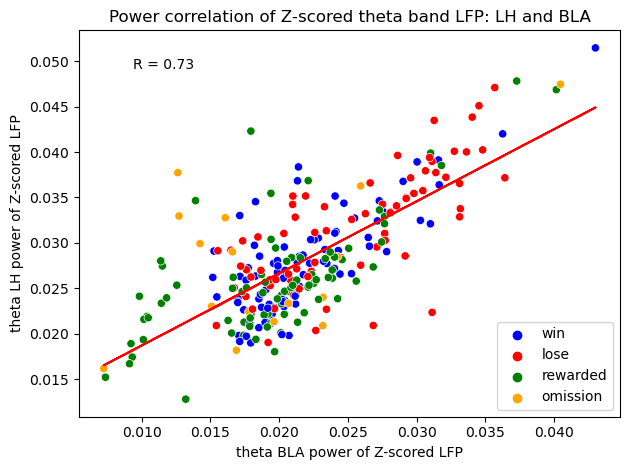

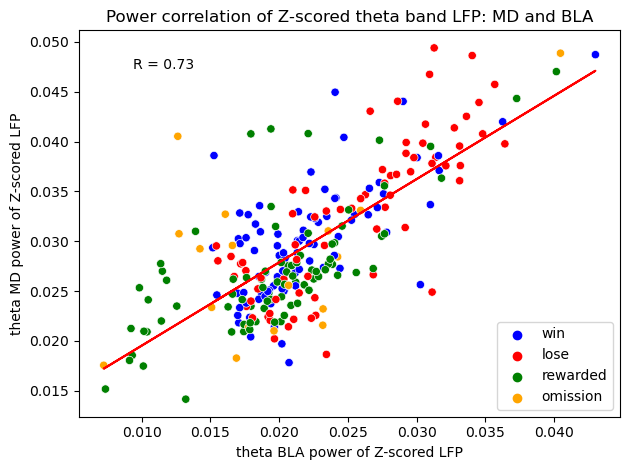

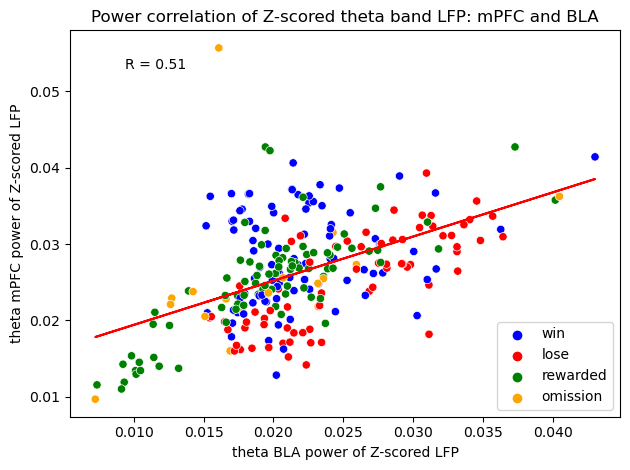

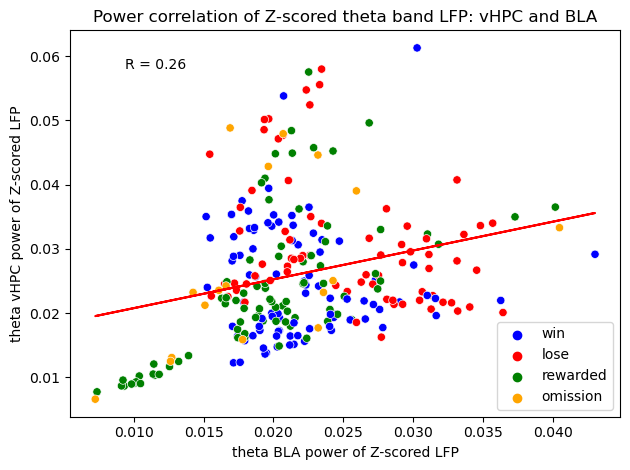

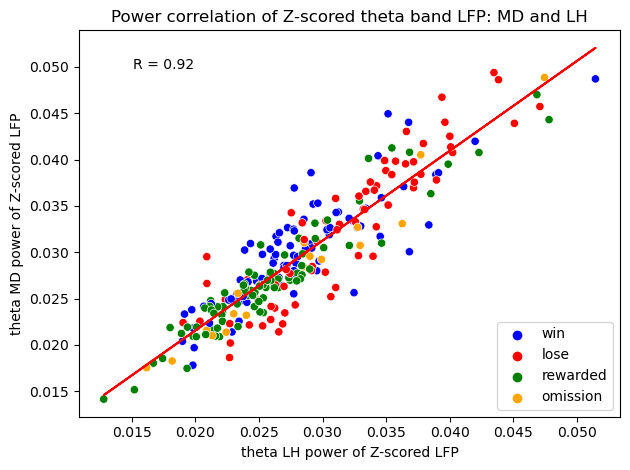

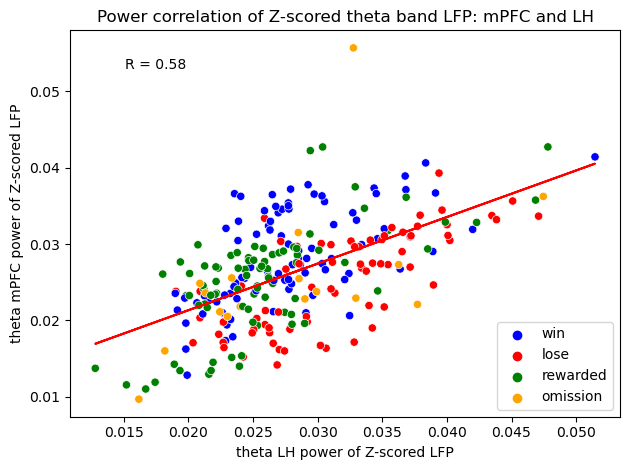

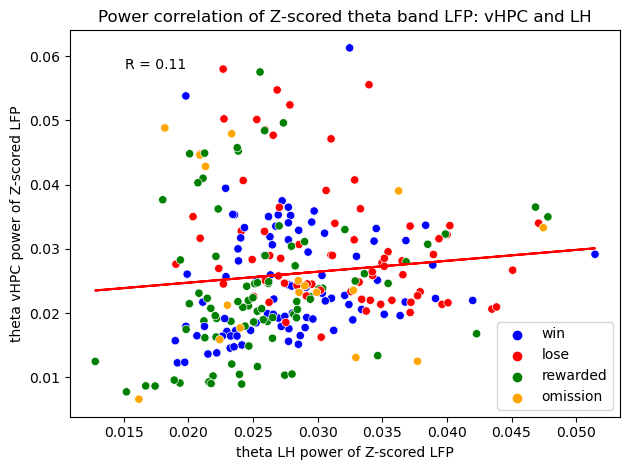

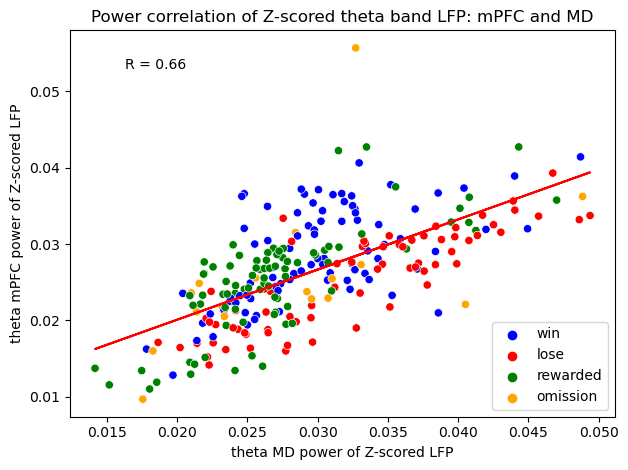

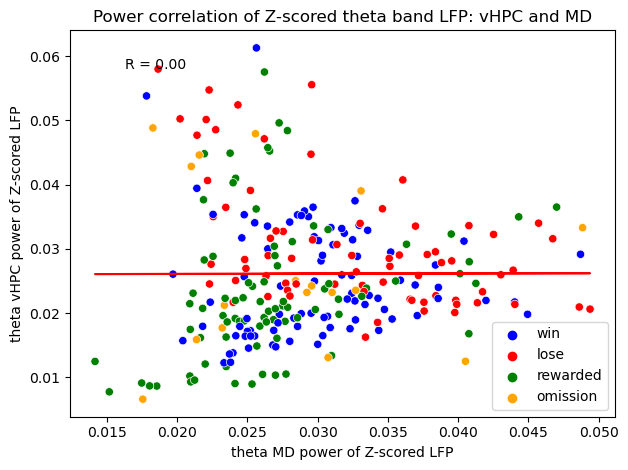

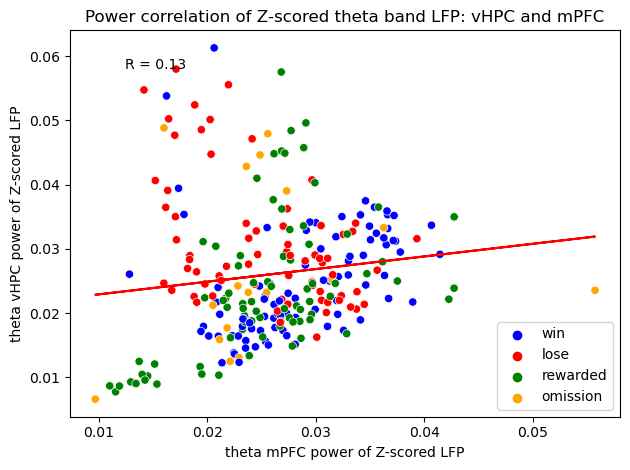

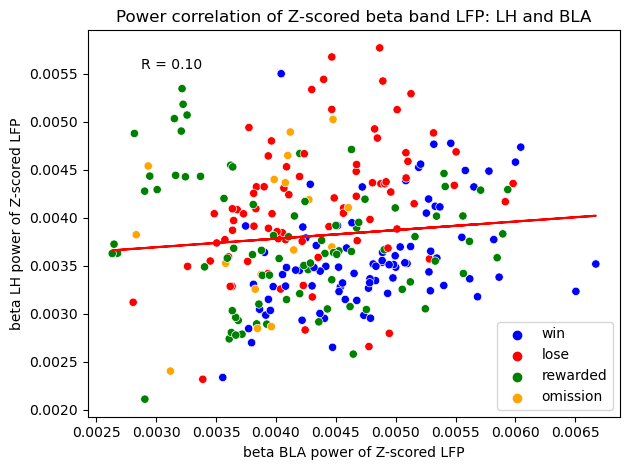

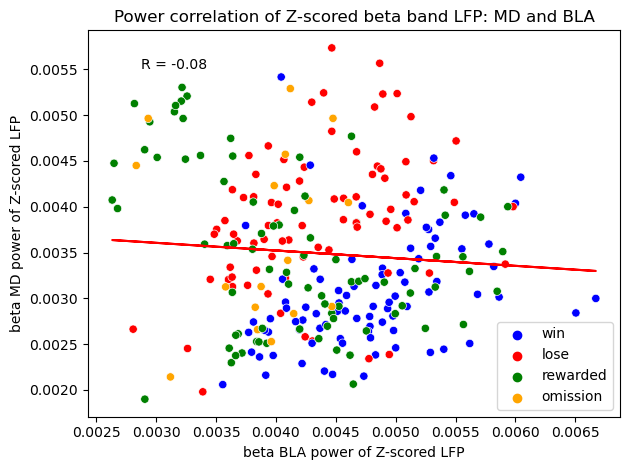

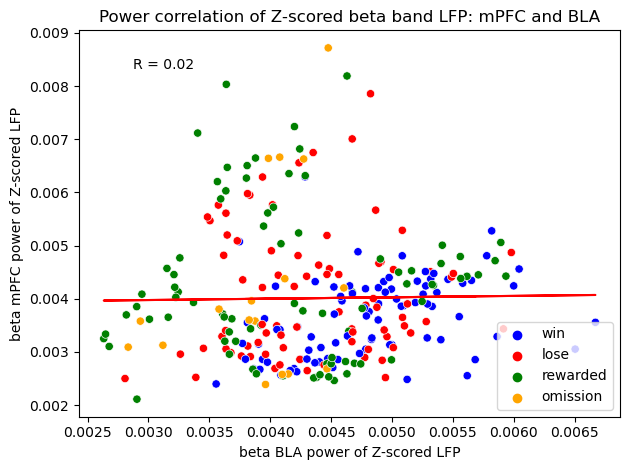

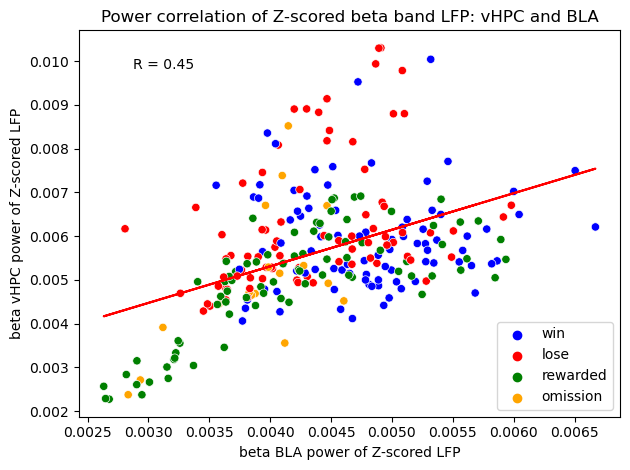

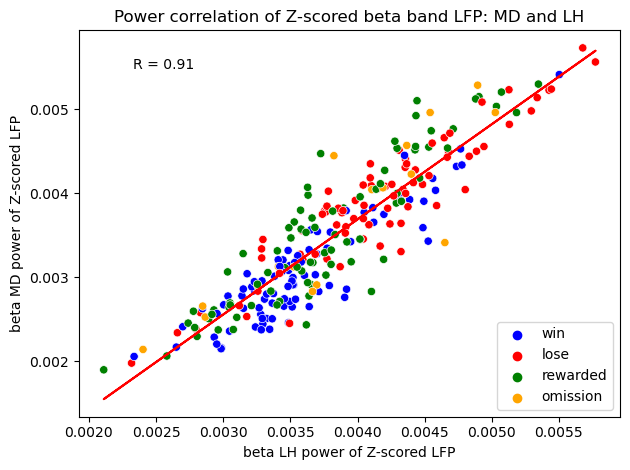

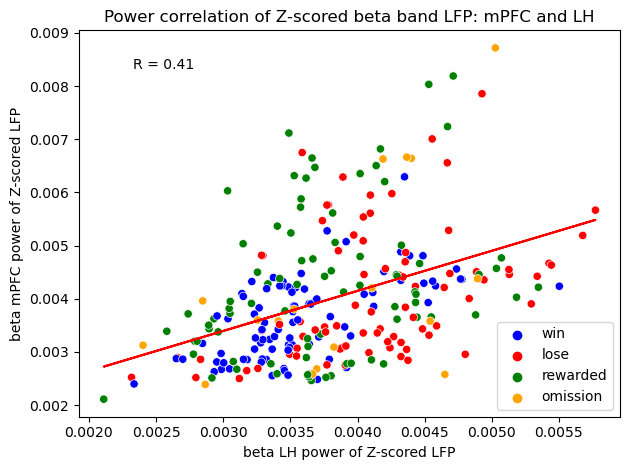

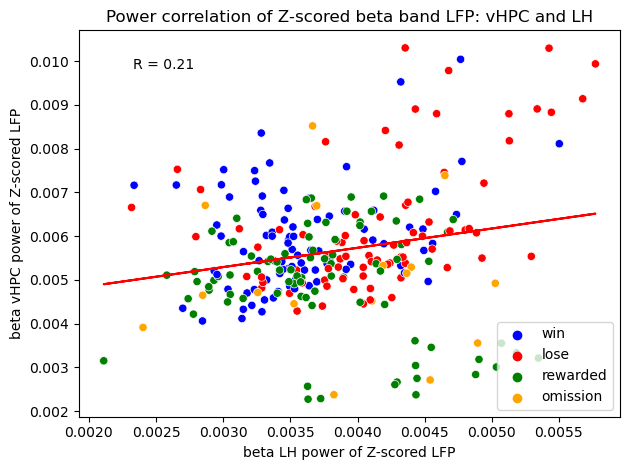

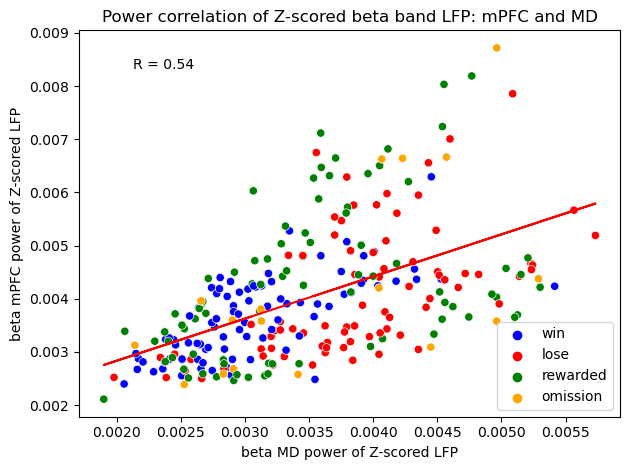

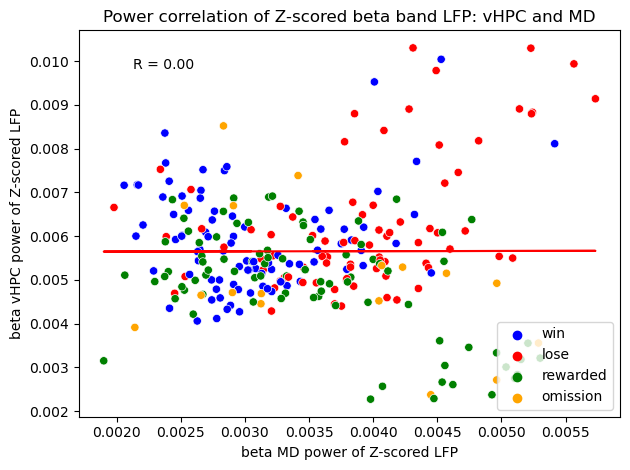

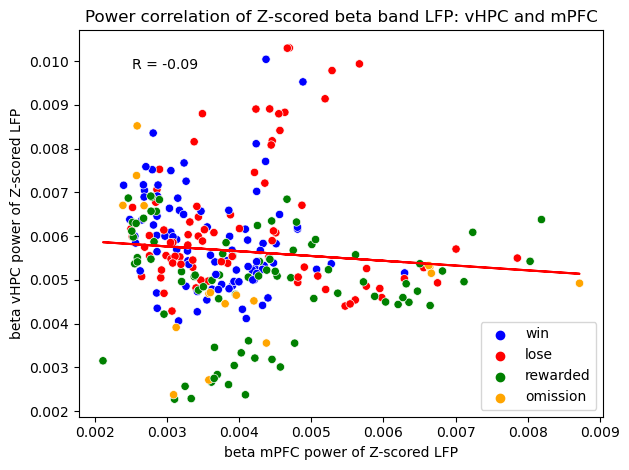

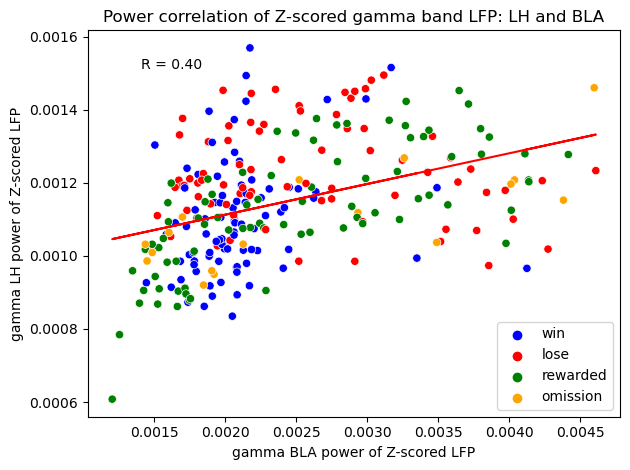

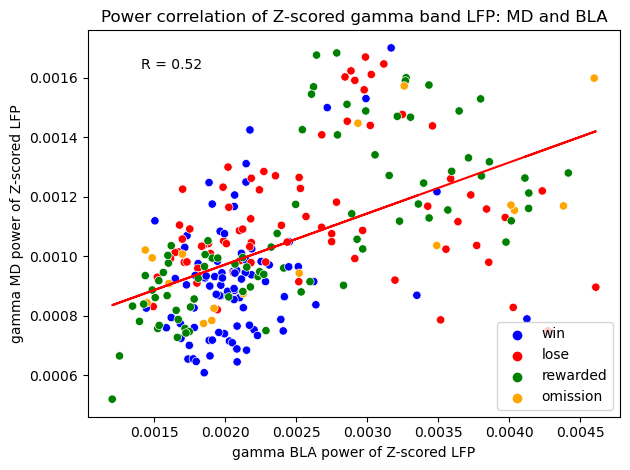

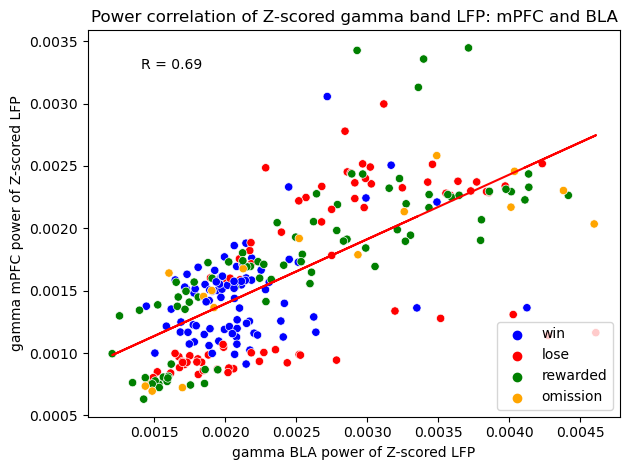

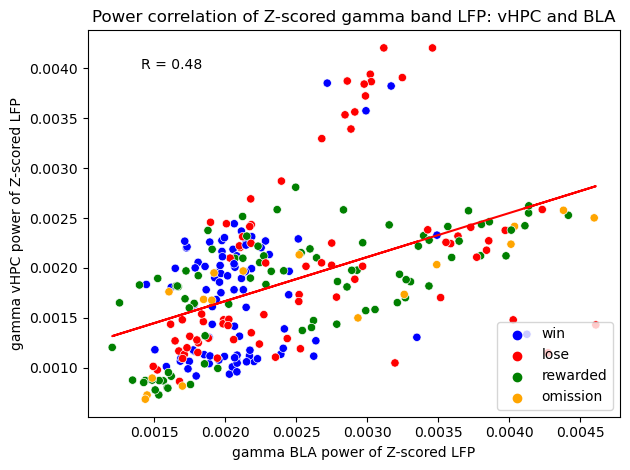

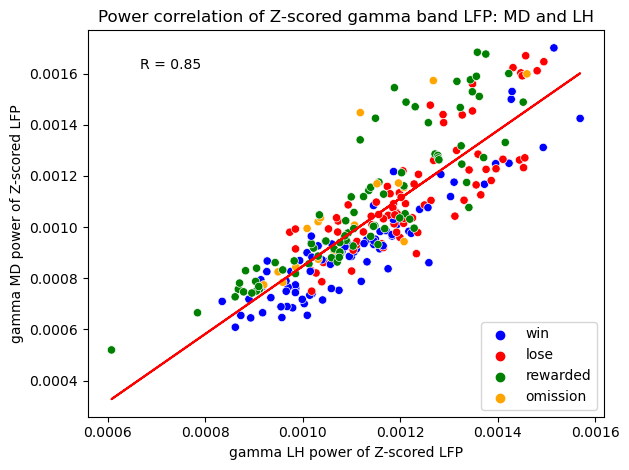

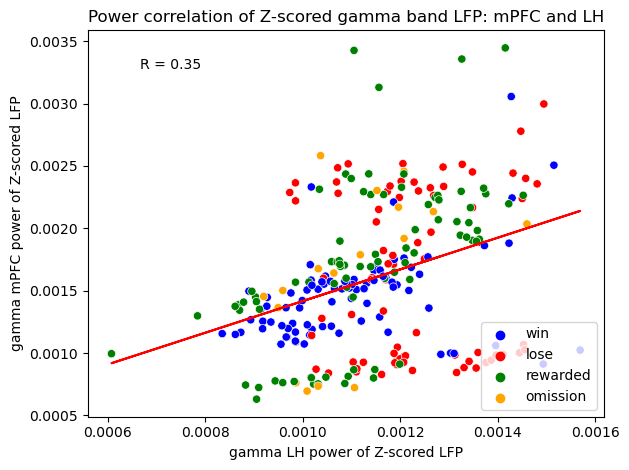

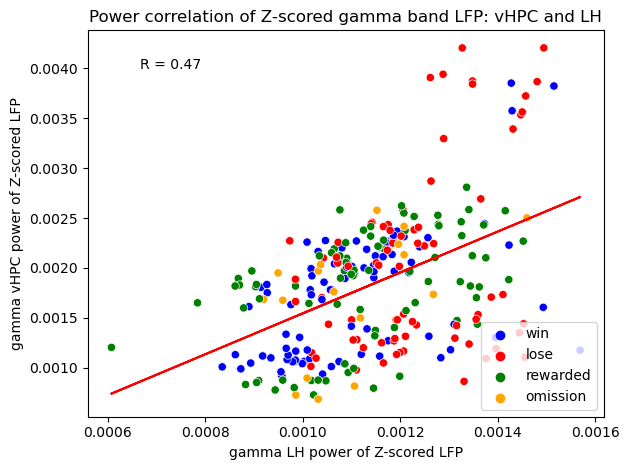

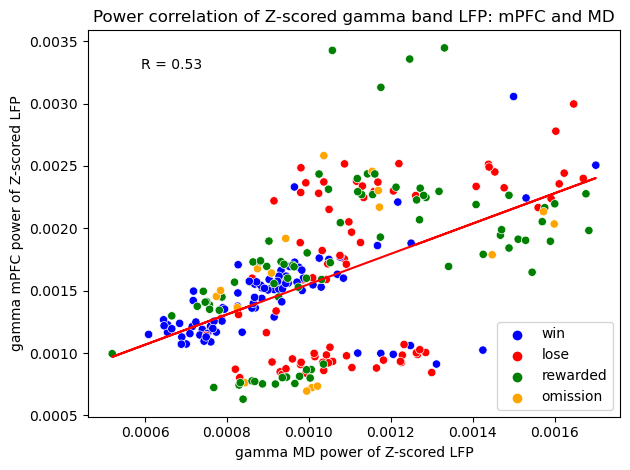

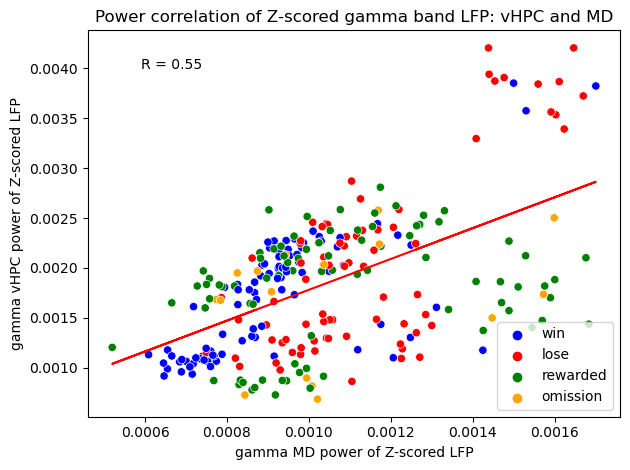

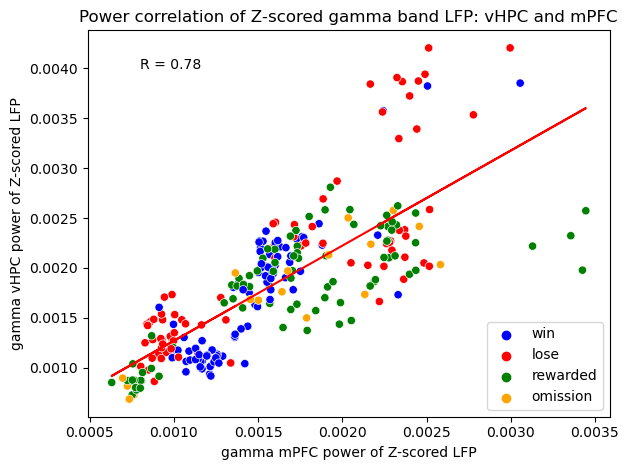

In [41]:
for band in ALL_BANDS:
    for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        x = band_to_power_correlation[band]["outlier_removed_df"][region_1]
        y = band_to_power_correlation[band]["outlier_removed_df"][region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=band_to_power_correlation[band]["outlier_removed_df"], hue='trial_outcome', palette=BASELINE_OUTCOME_TO_COLOR)
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation of Z-scored {} band LFP: {} and {}".format(band, region_2_basename, region_1_basename))
        plt.xlabel('{} {} power of Z-scored LFP'.format(band, region_1_basename))
        plt.ylabel('{} {} power of Z-scored LFP'.format(band, region_2_basename))
        plt.legend(loc="lower right")
        plt.tight_layout()
        # plt.savefig("./proc/power_correlation/zscored/{}/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, region_1_basename, region_2_basename, band))
        # Display the plot
        plt.show()




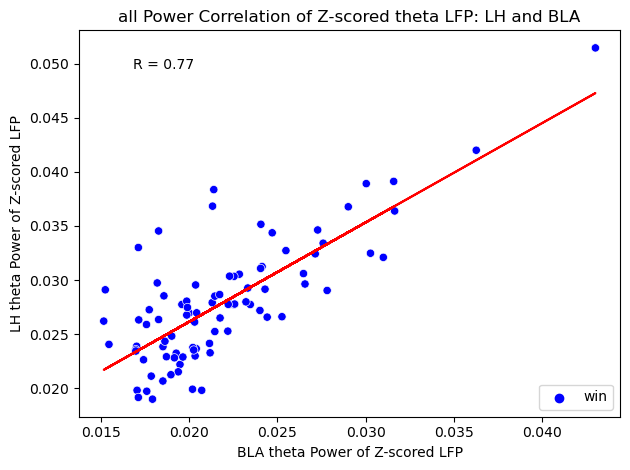

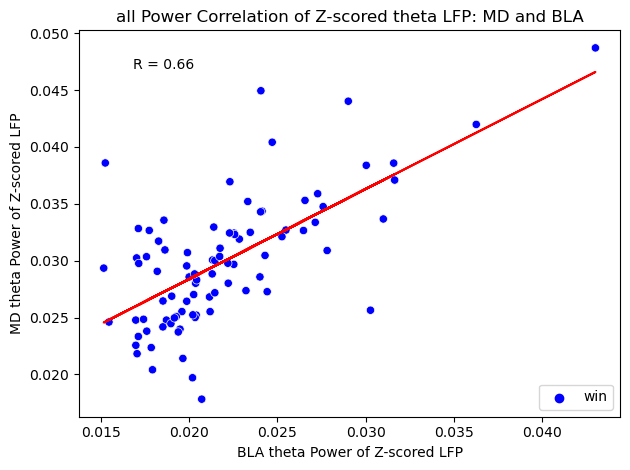

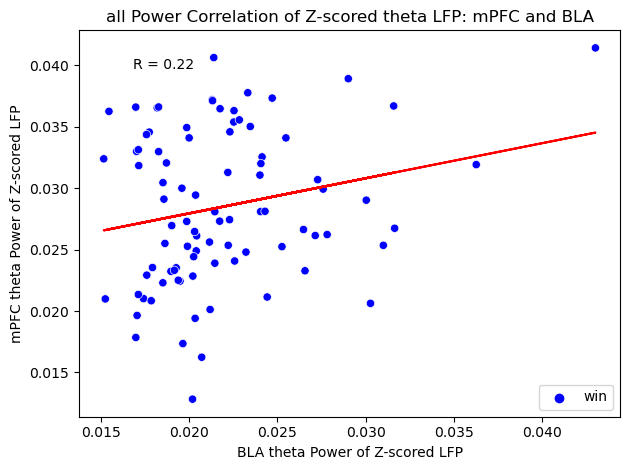

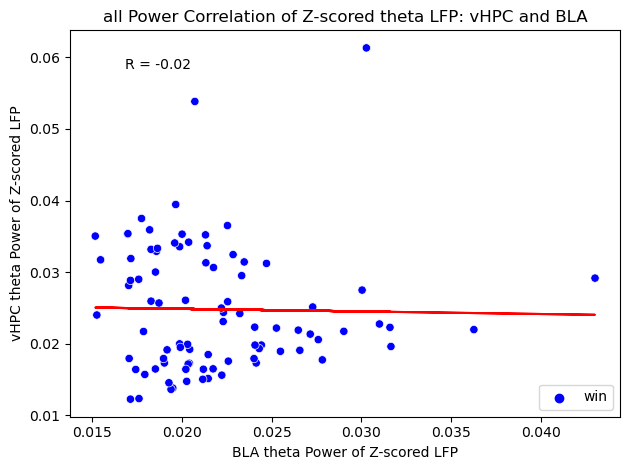

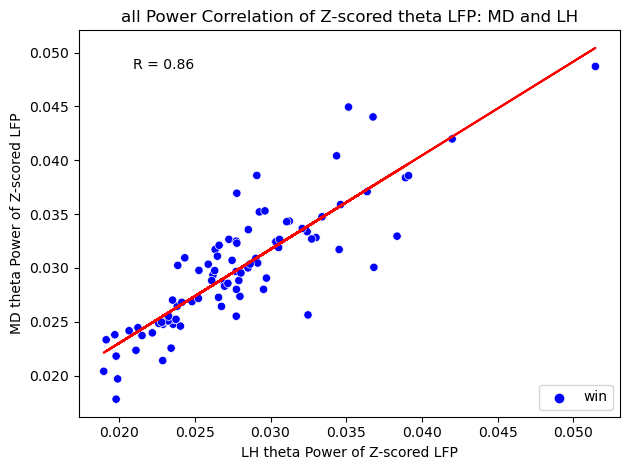

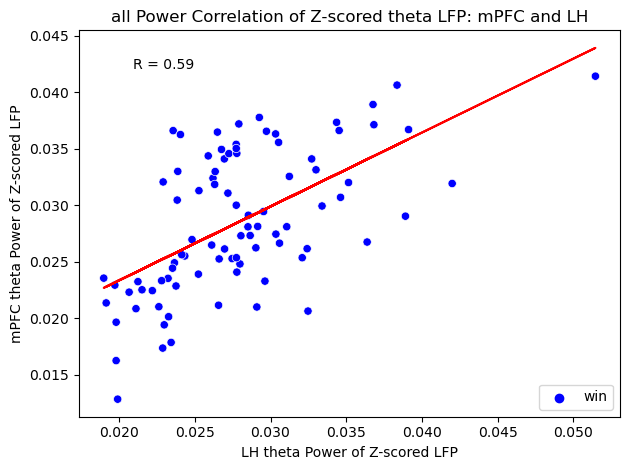

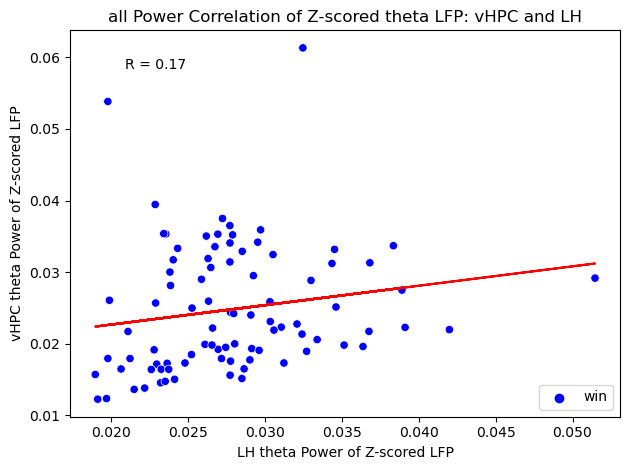

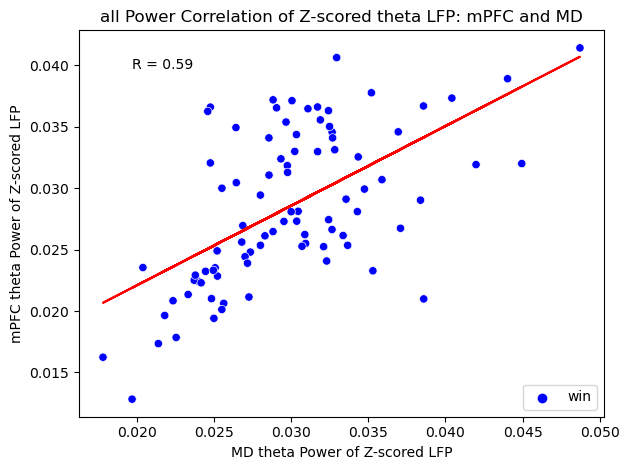

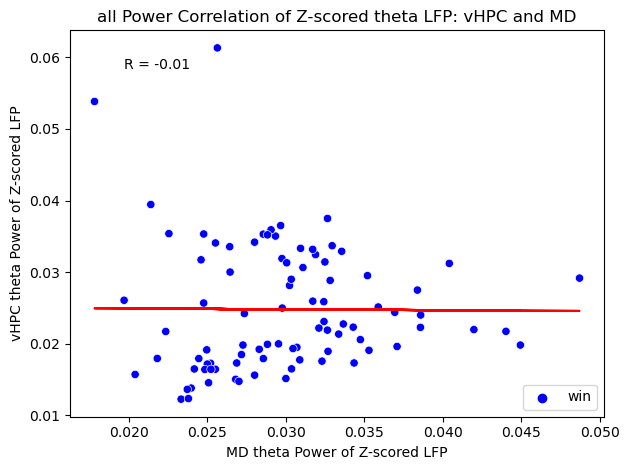

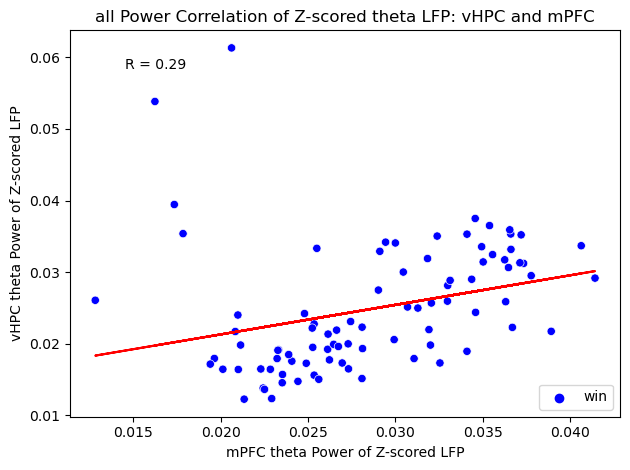

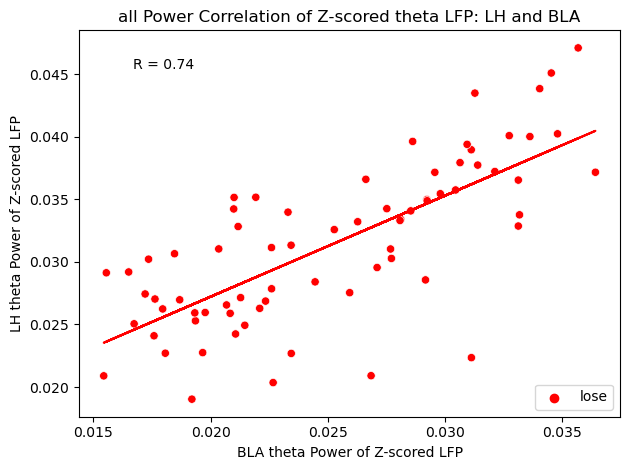

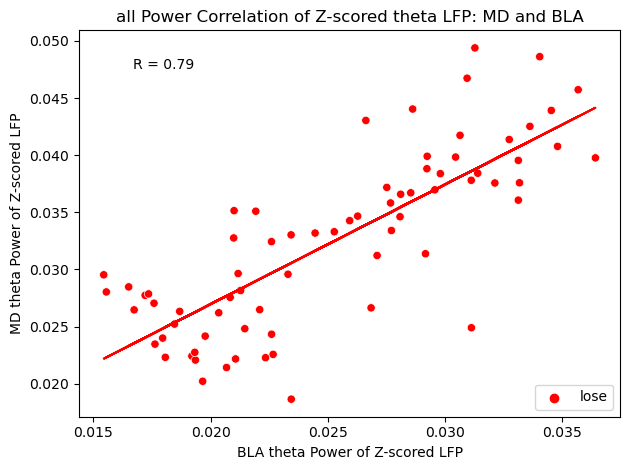

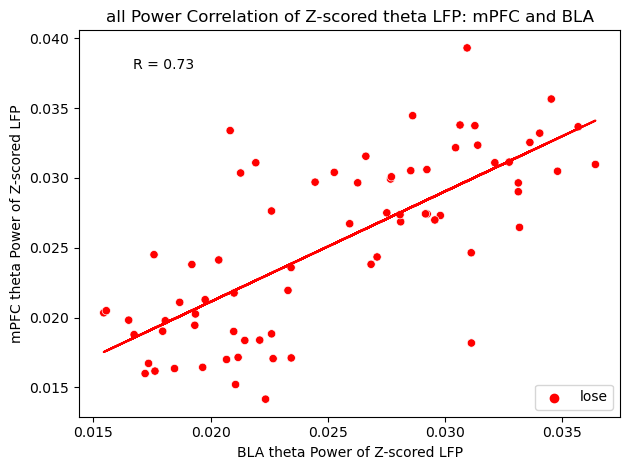

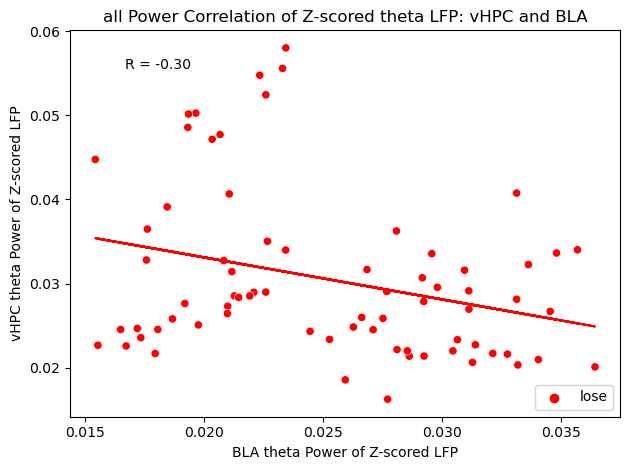

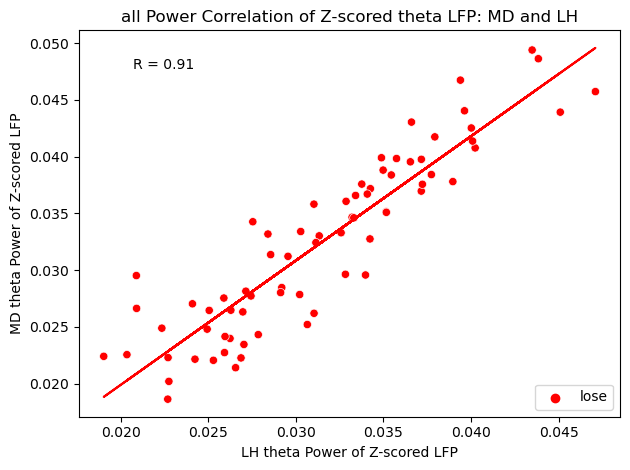

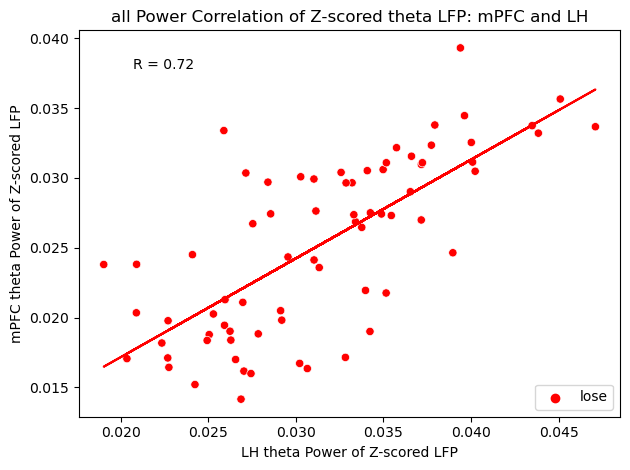

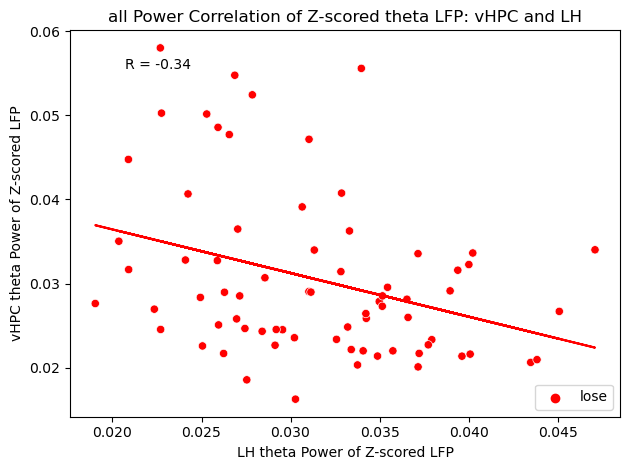

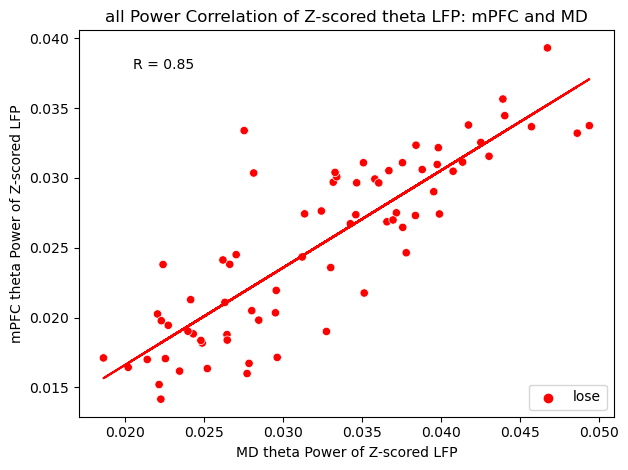

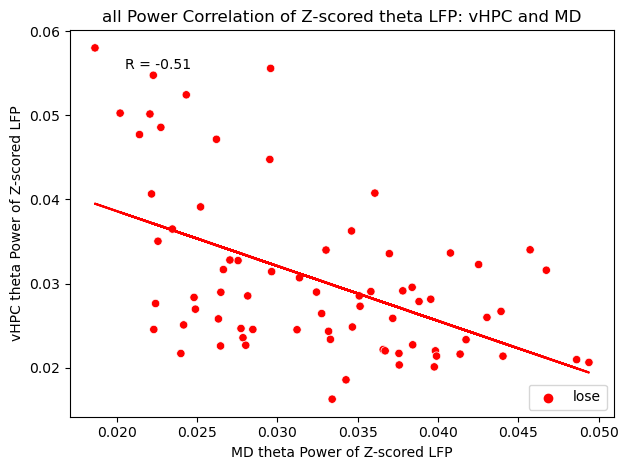

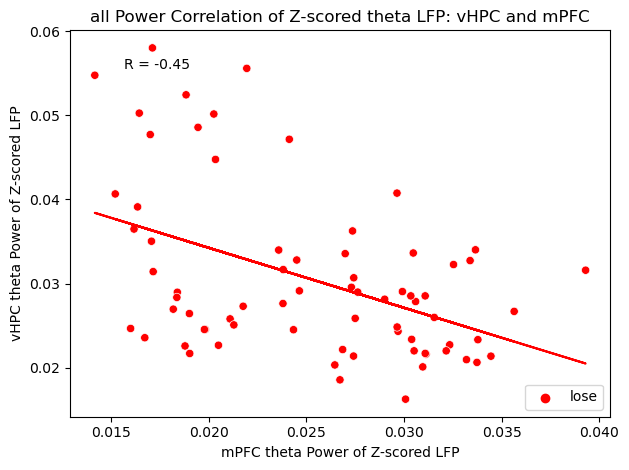

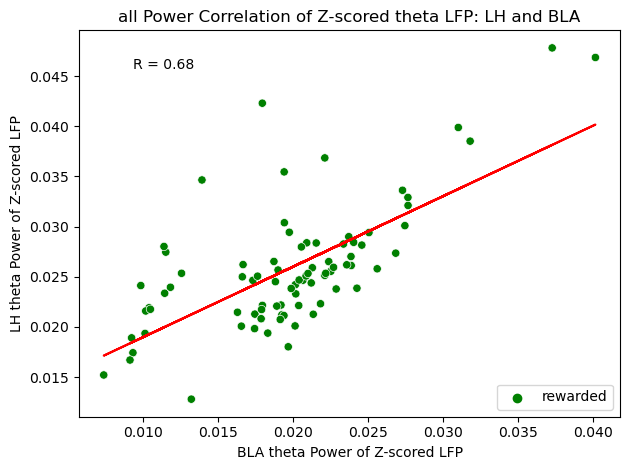

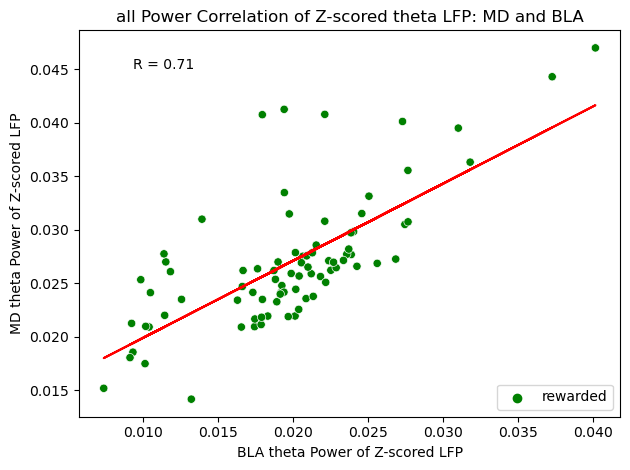

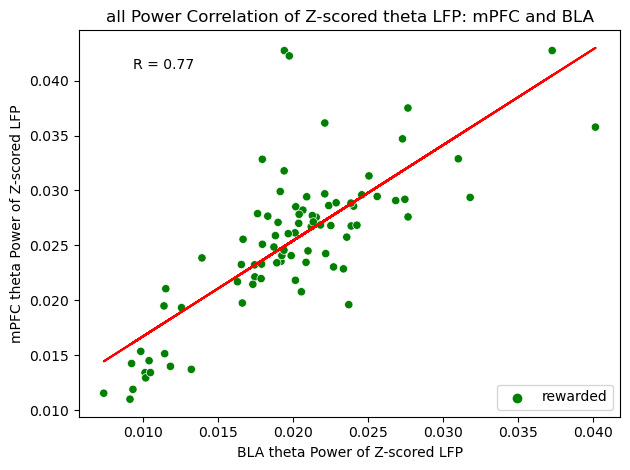

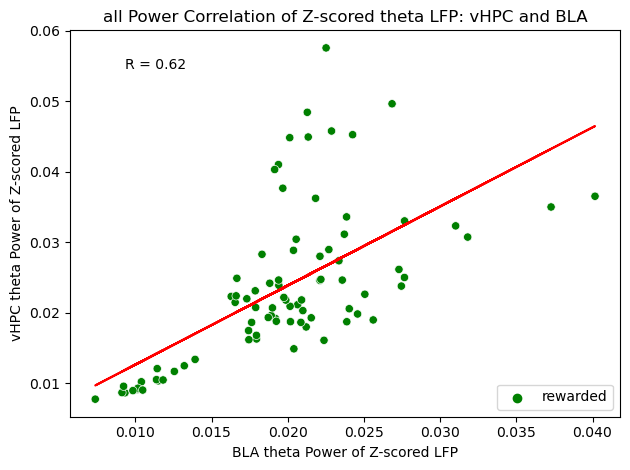

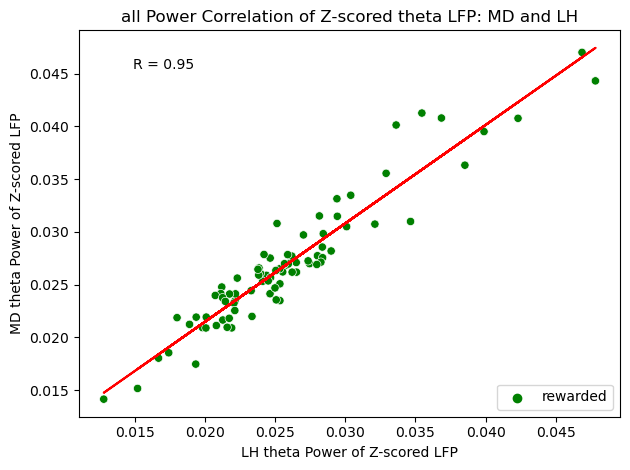

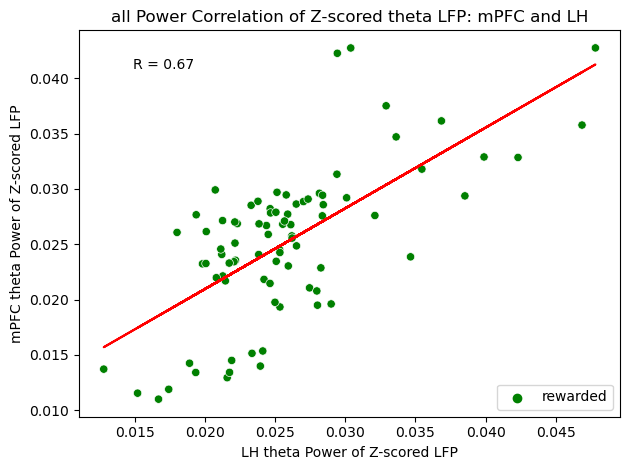

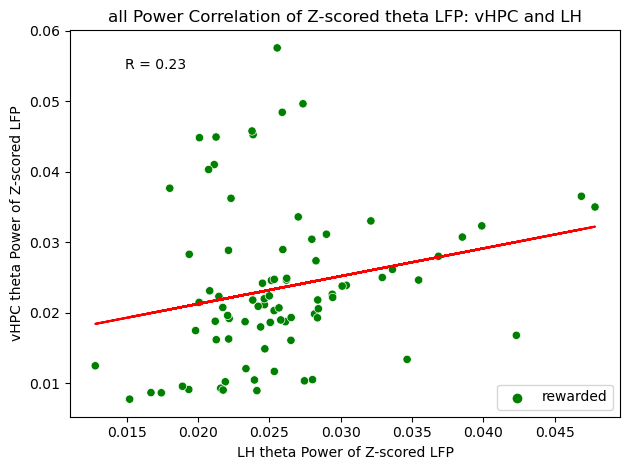

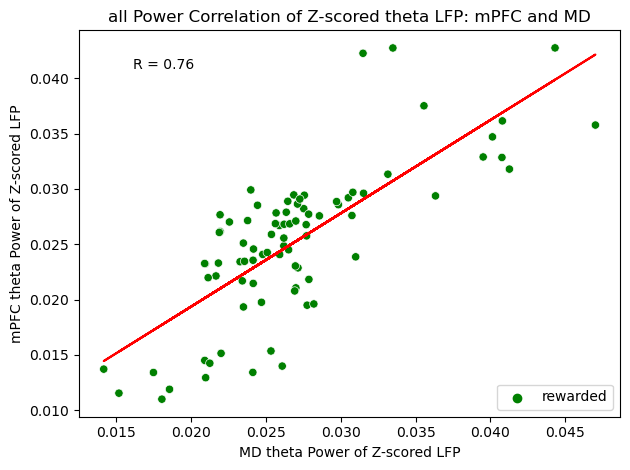

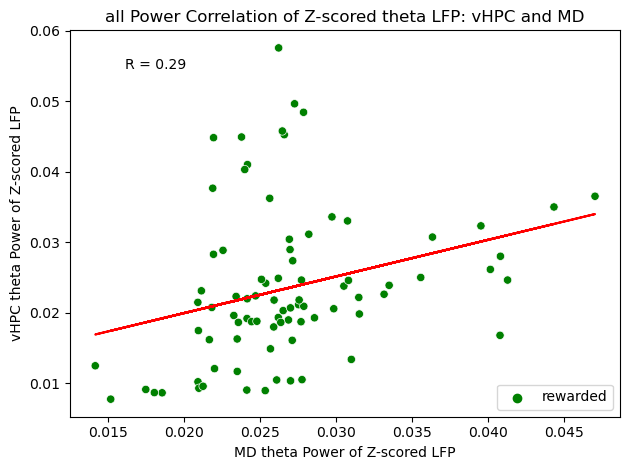

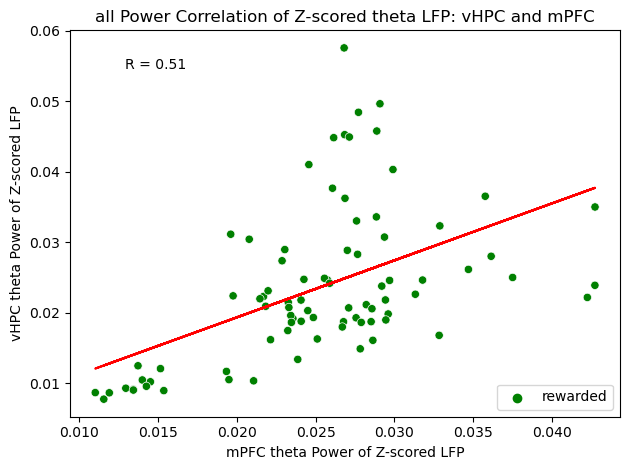

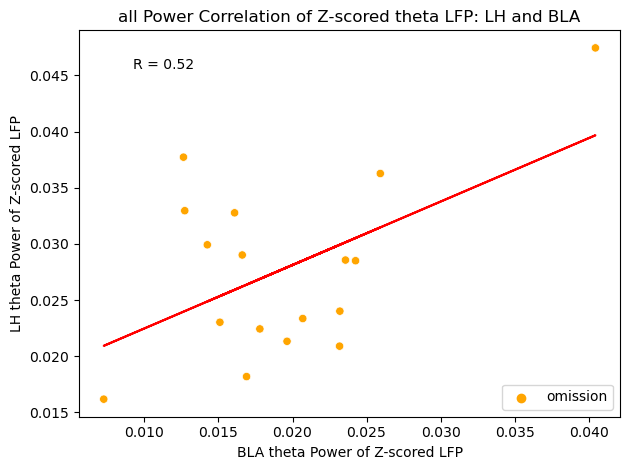

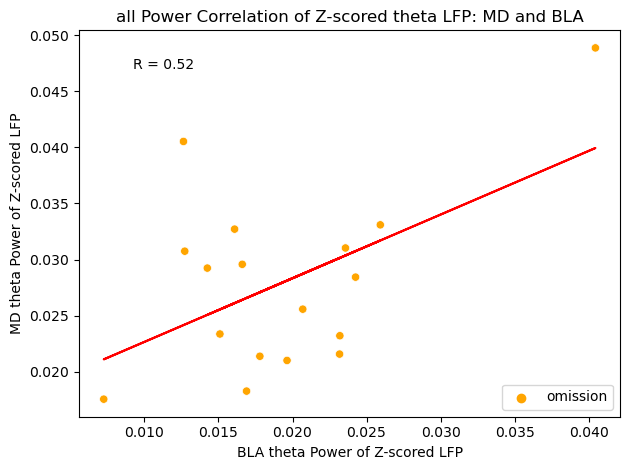

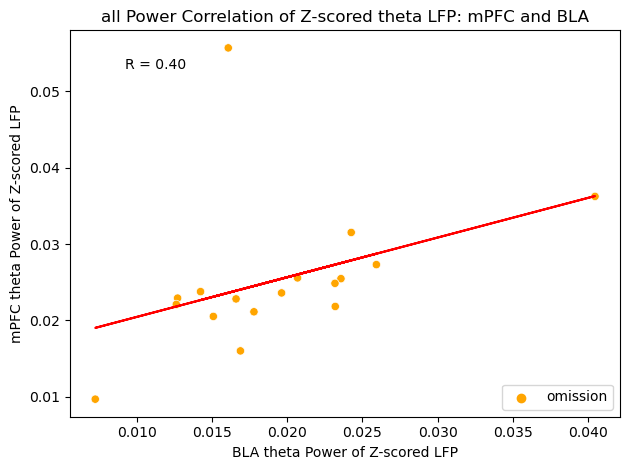

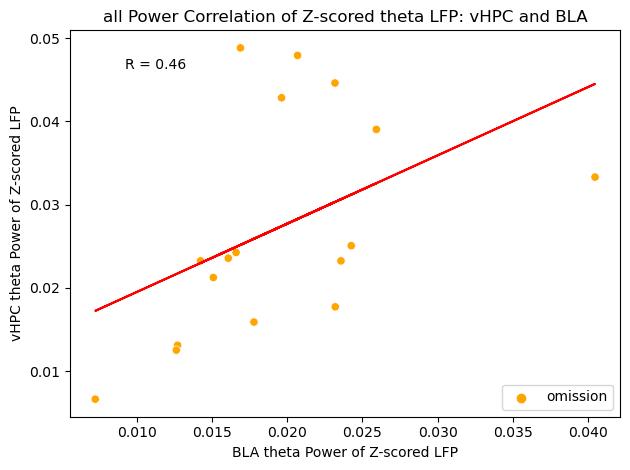

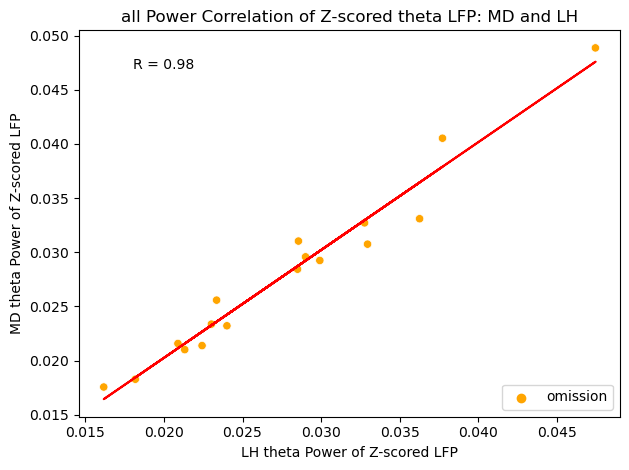

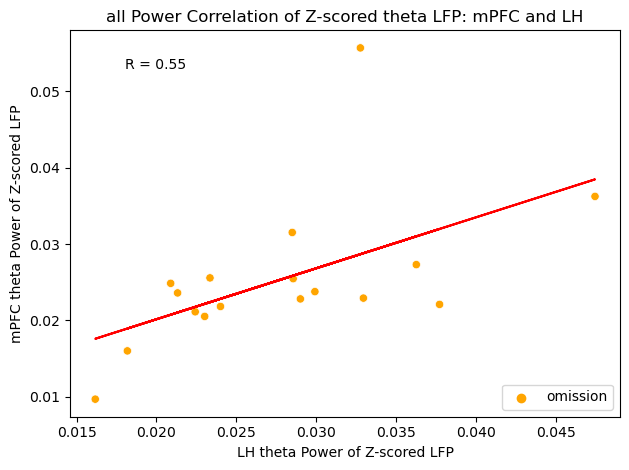

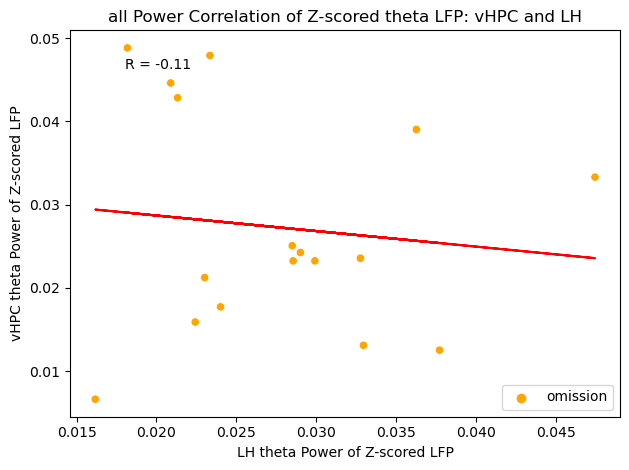

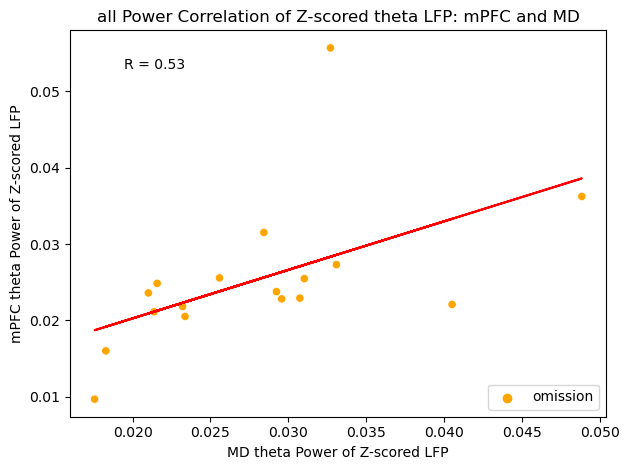

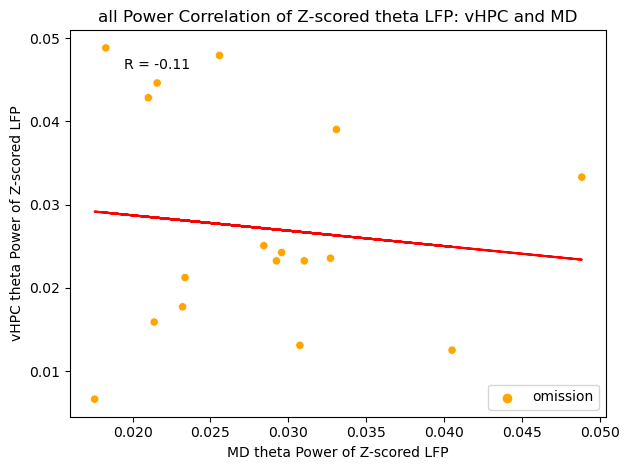

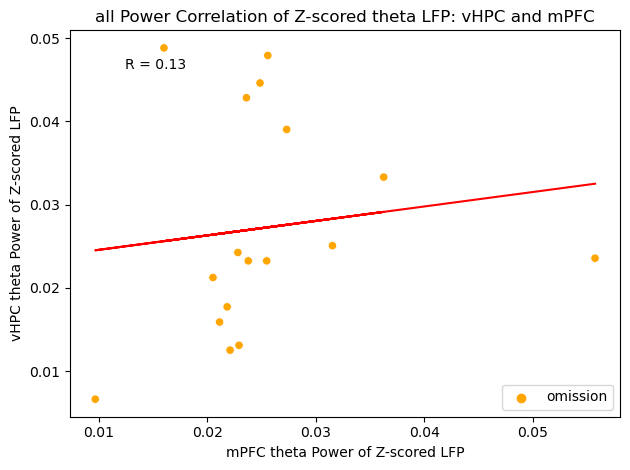

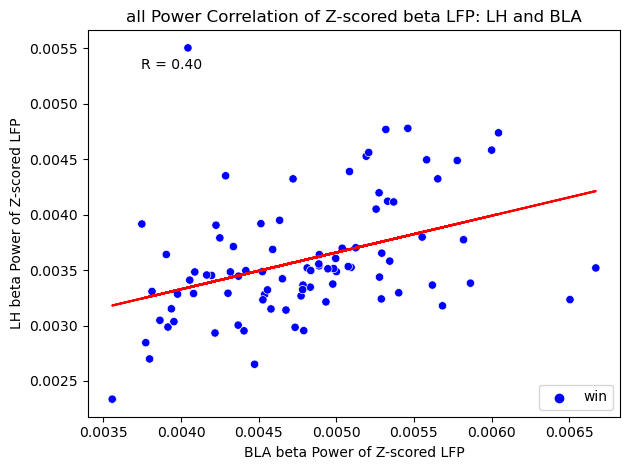

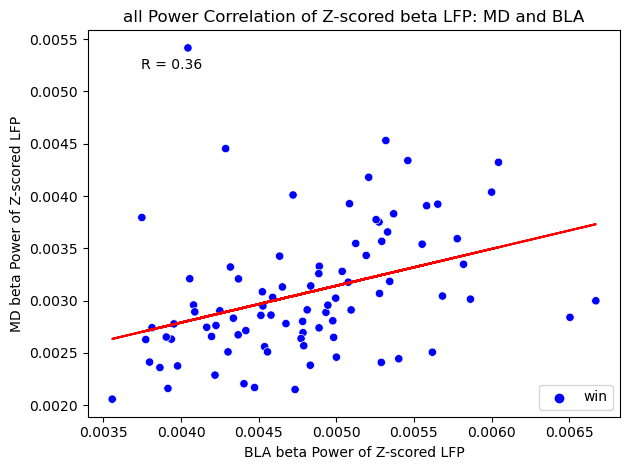

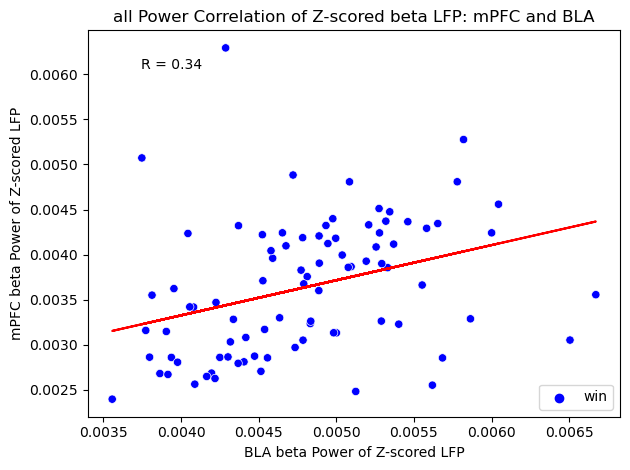

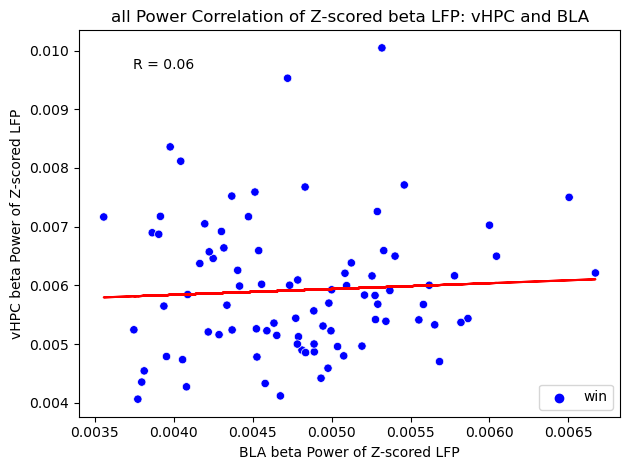

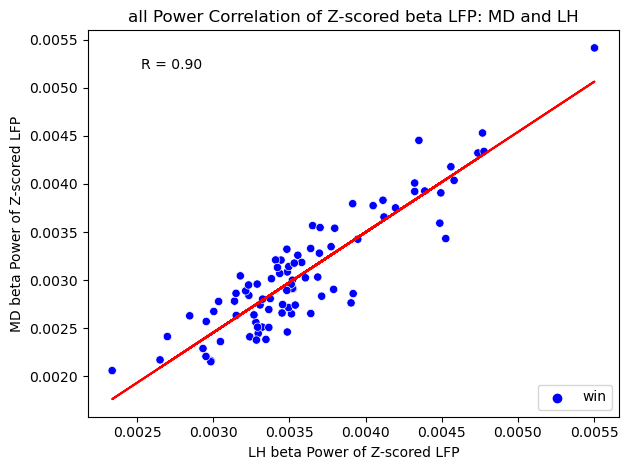

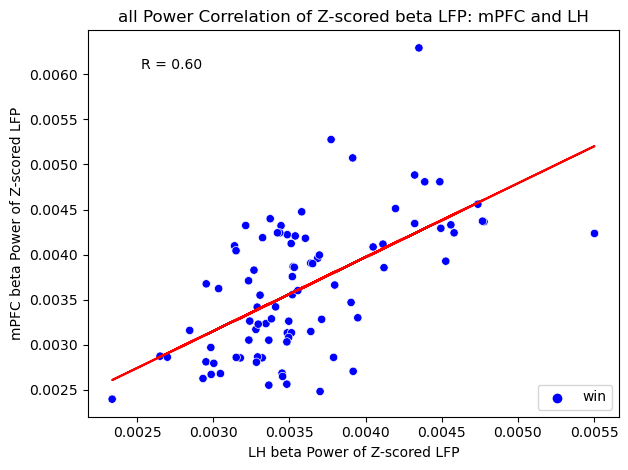

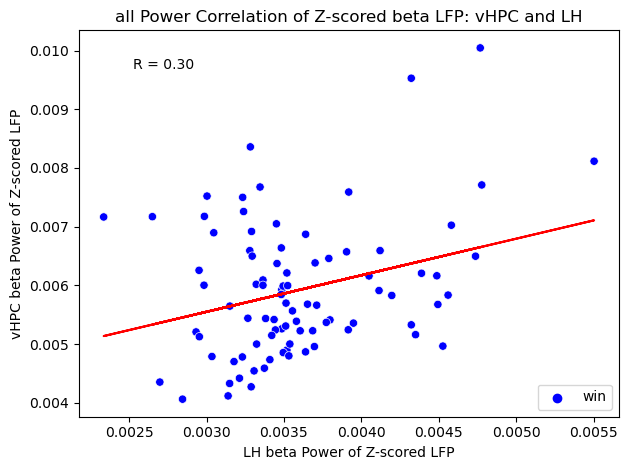

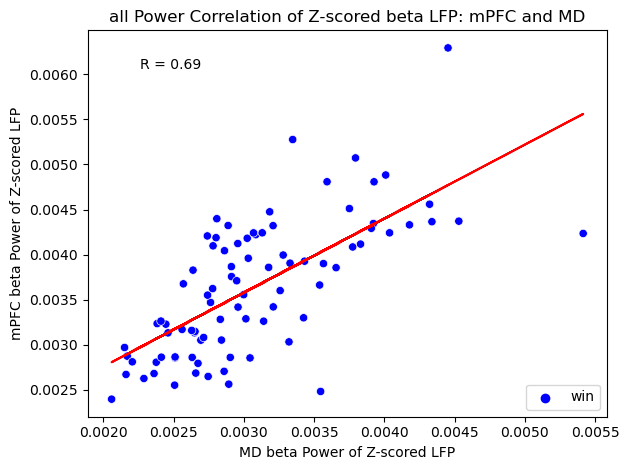

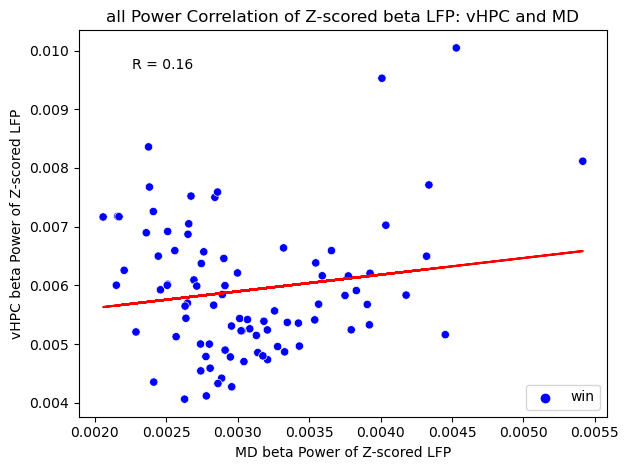

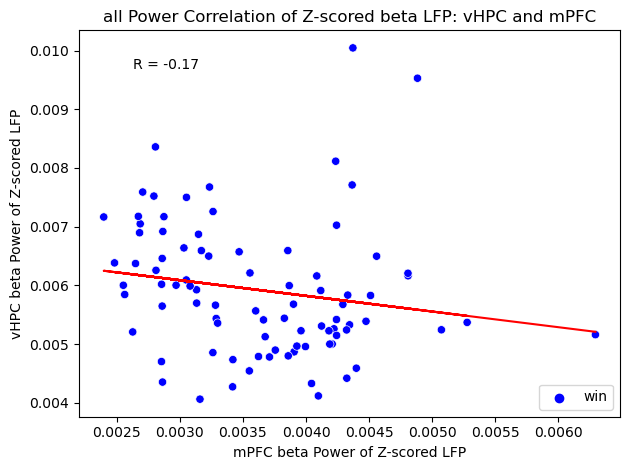

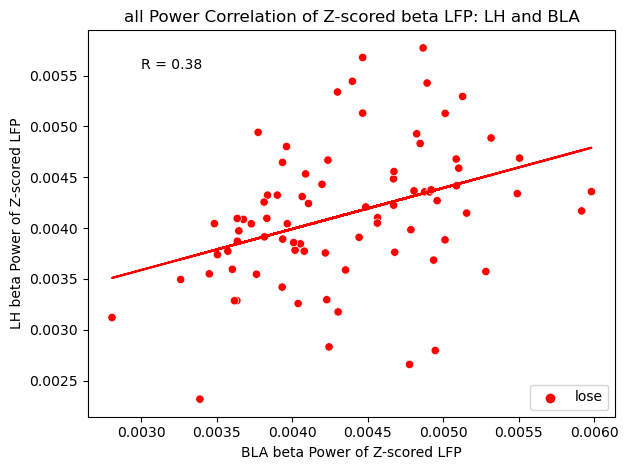

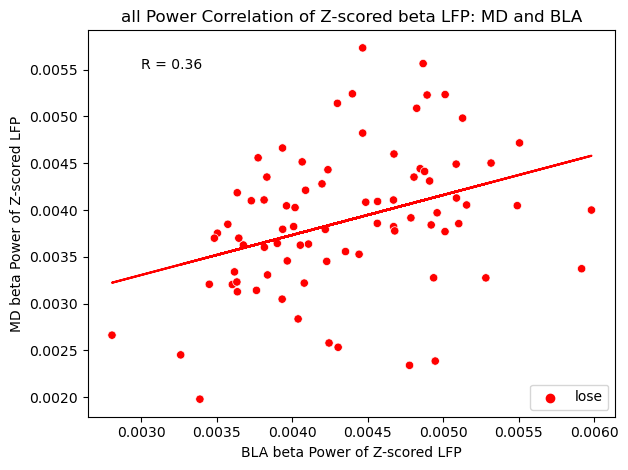

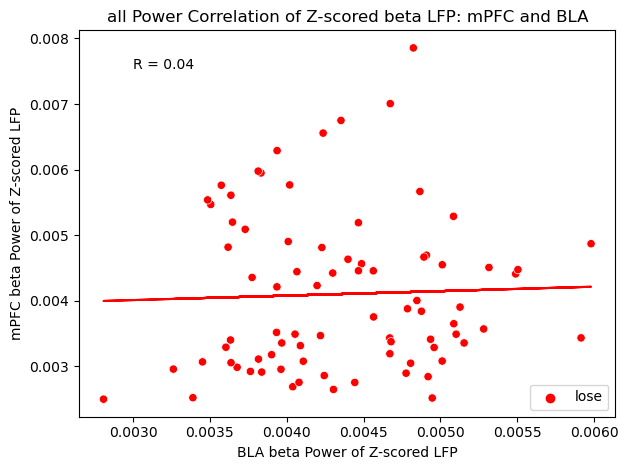

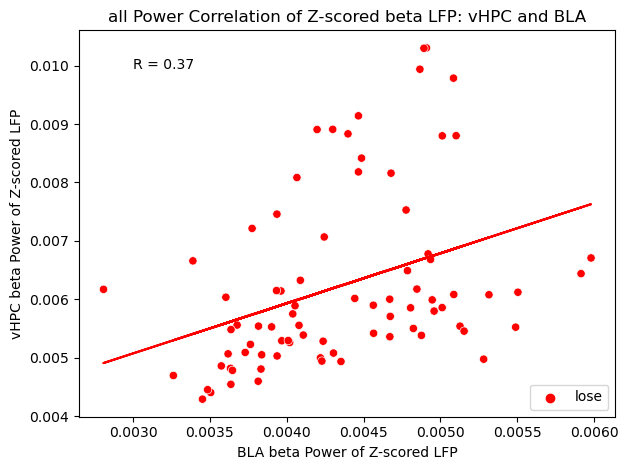

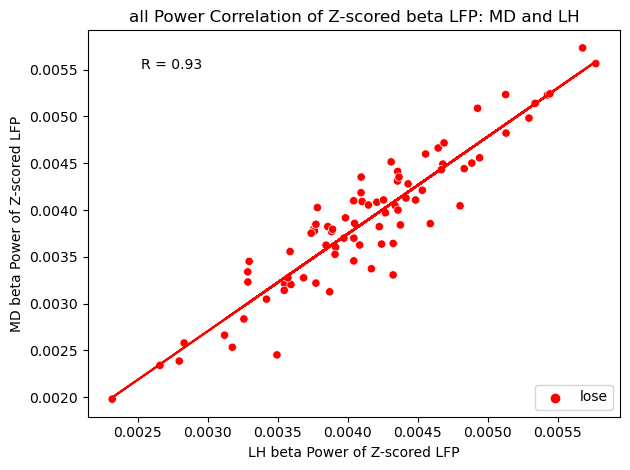

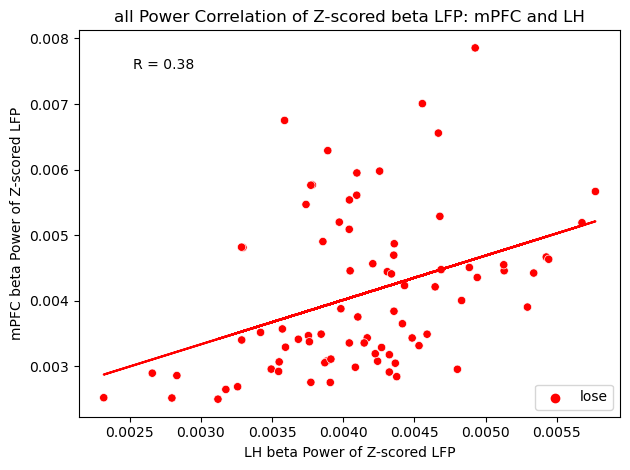

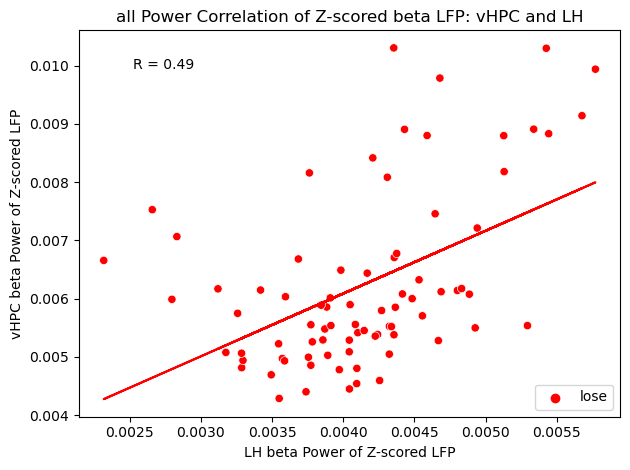

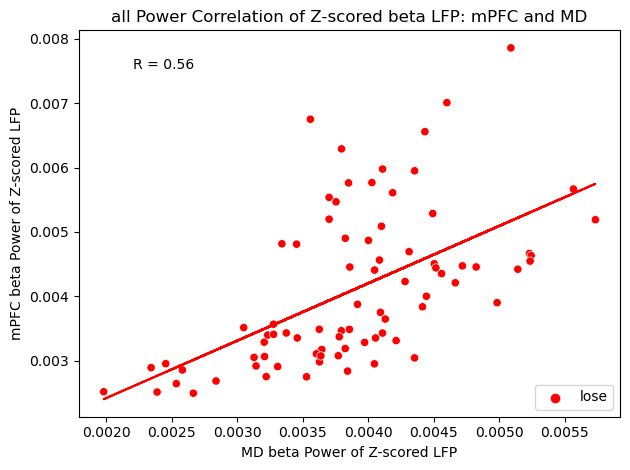

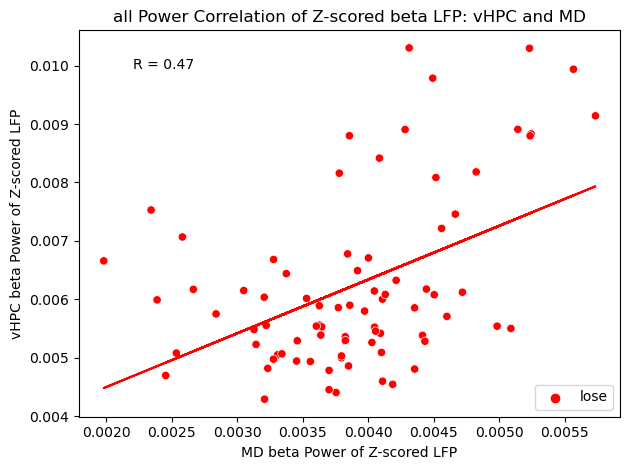

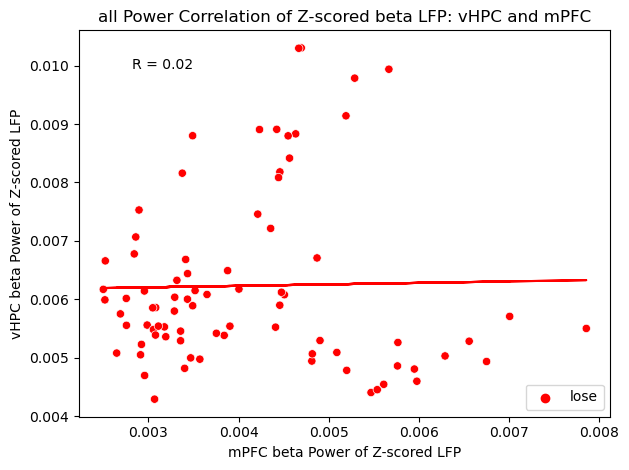

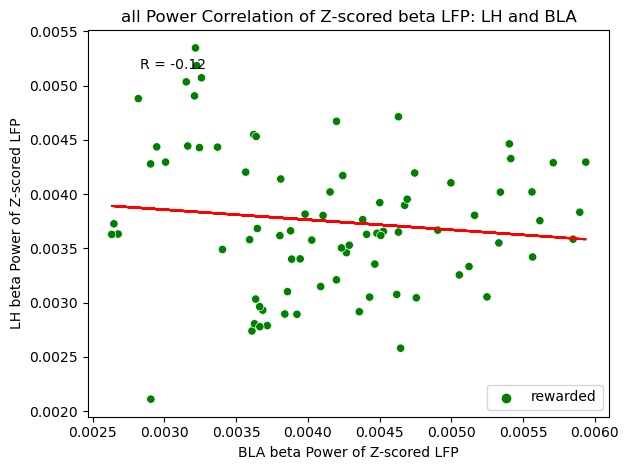

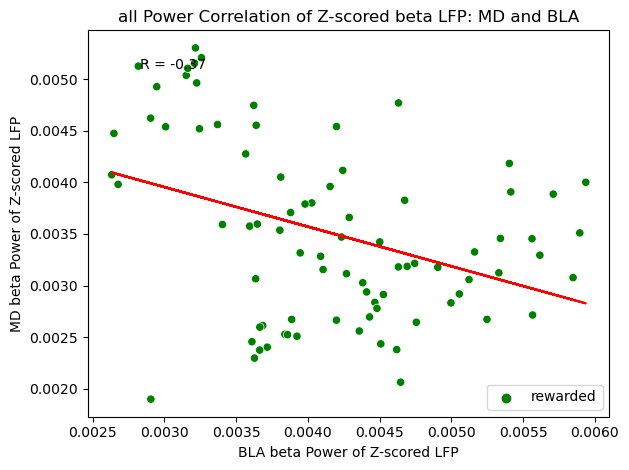

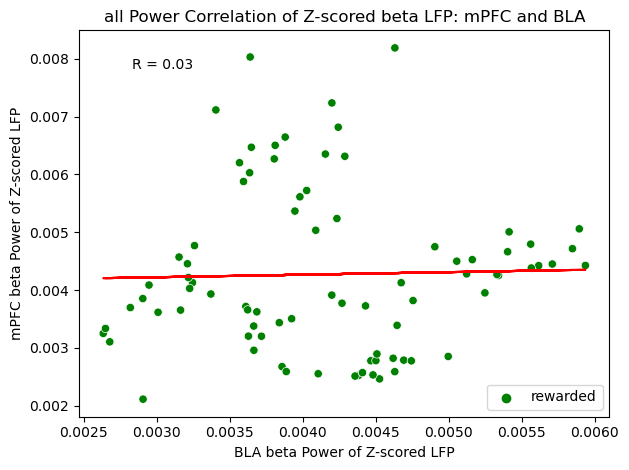

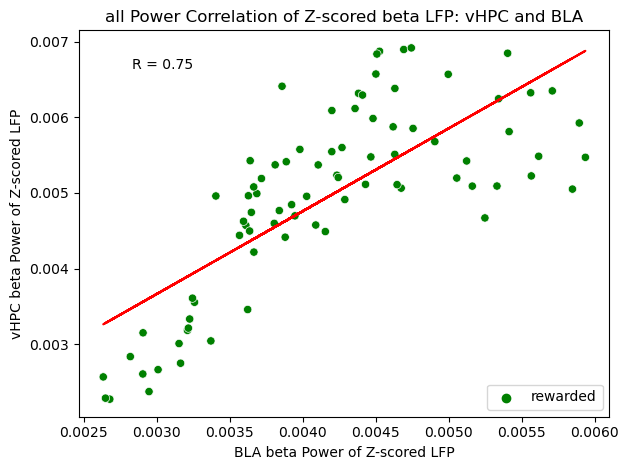

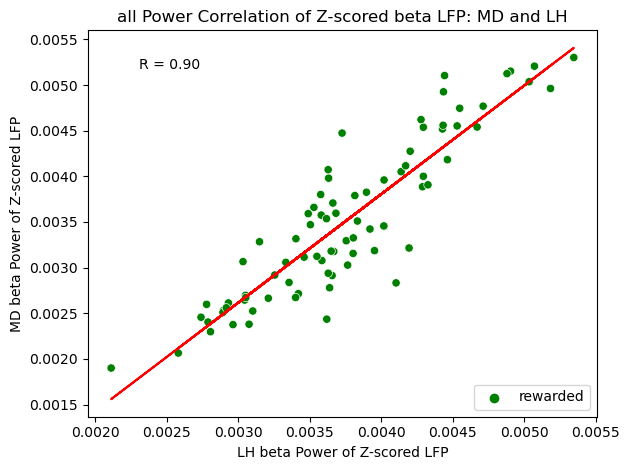

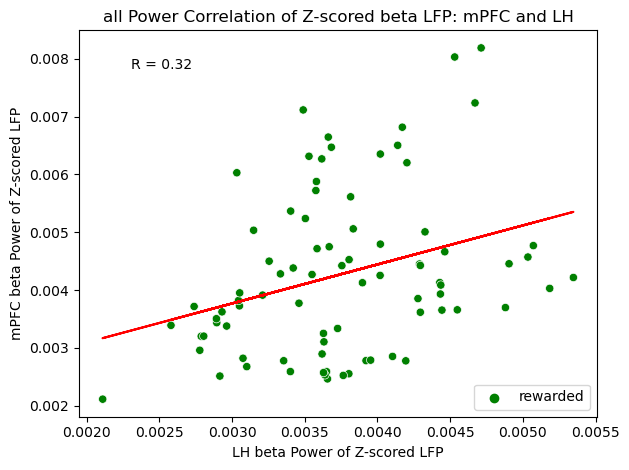

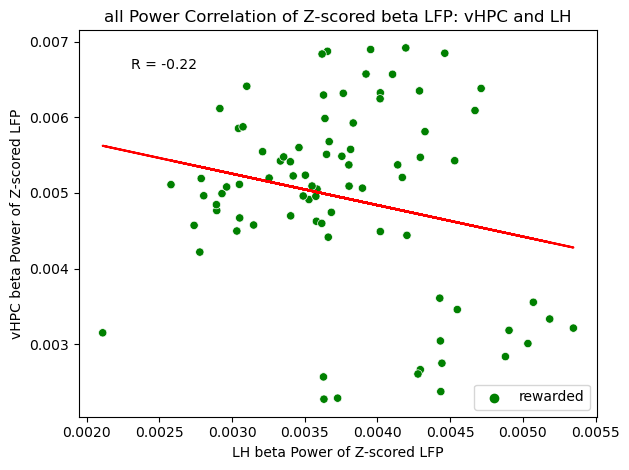

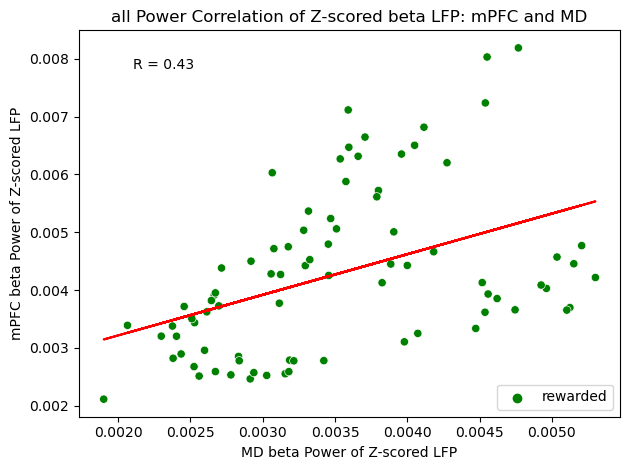

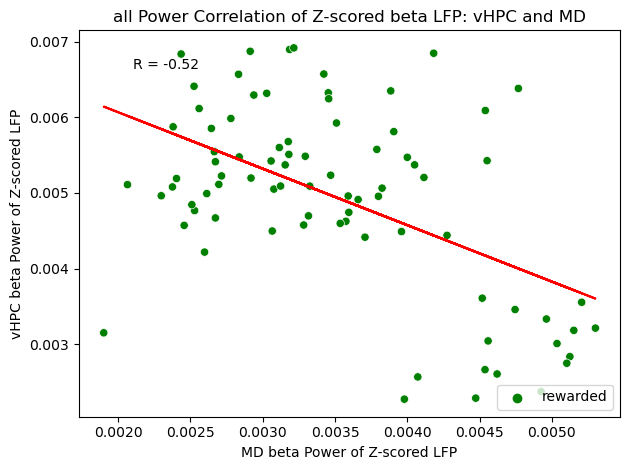

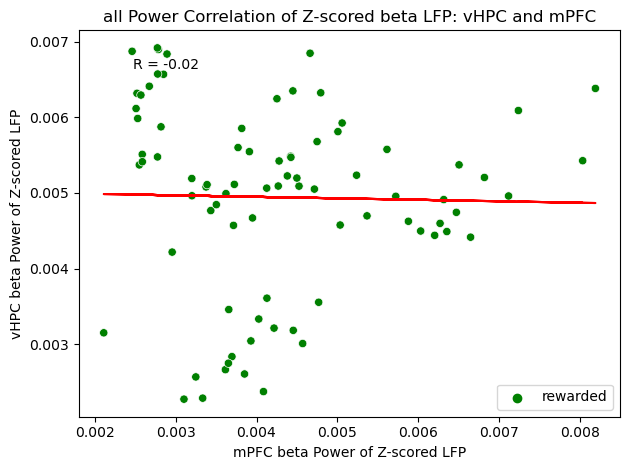

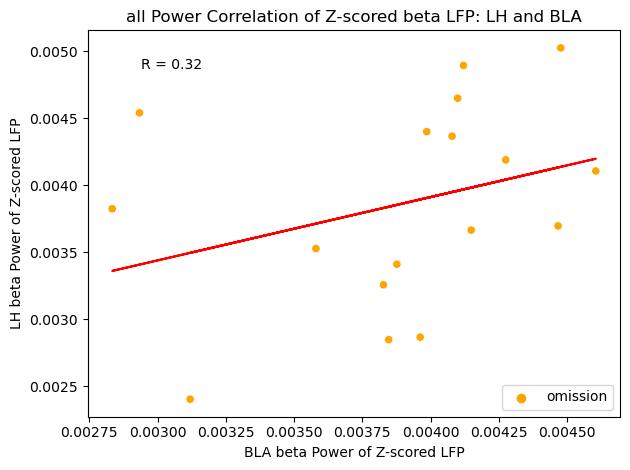

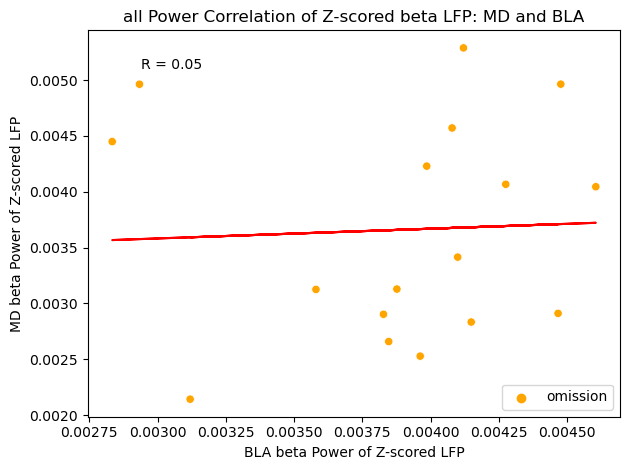

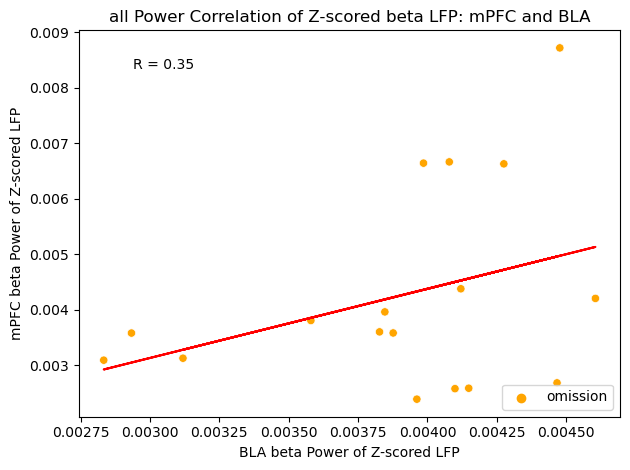

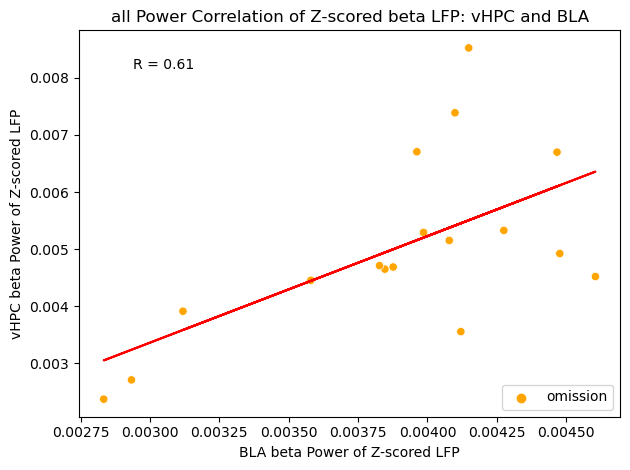

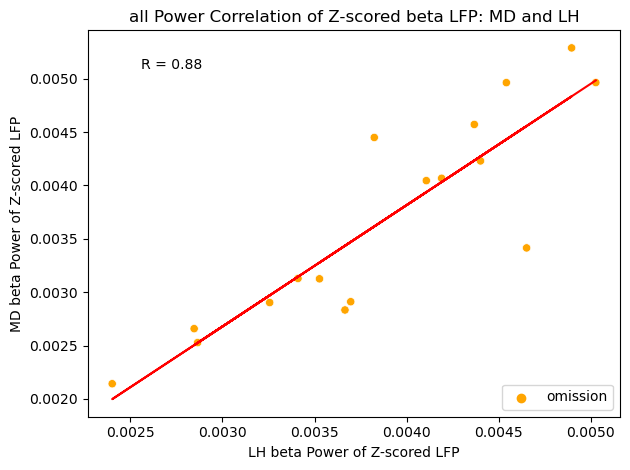

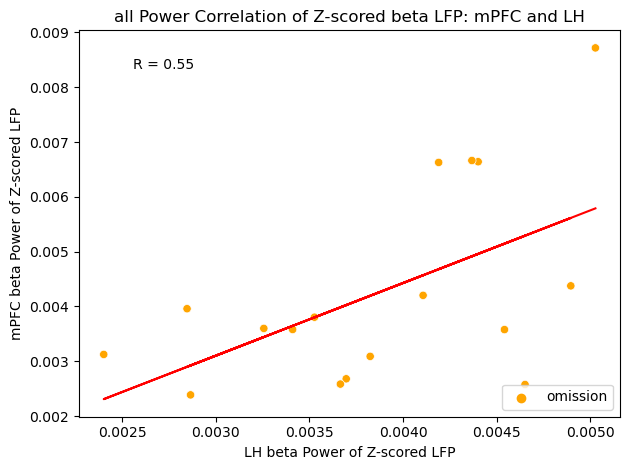

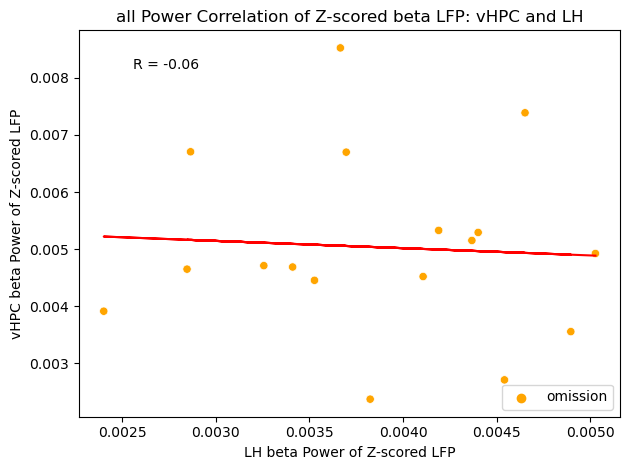

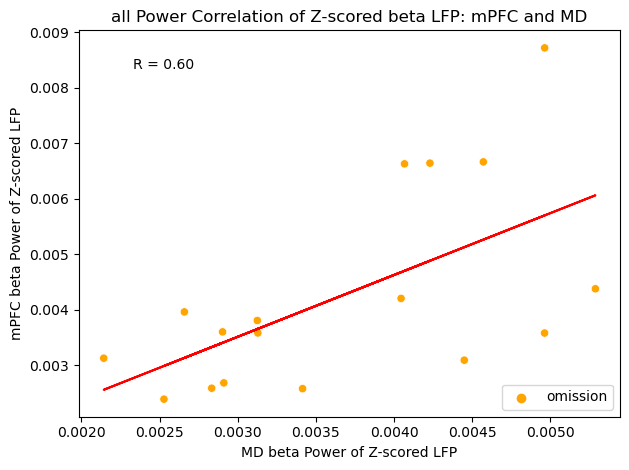

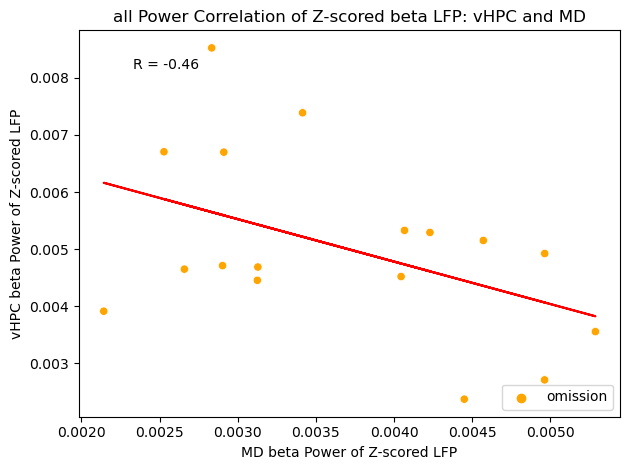

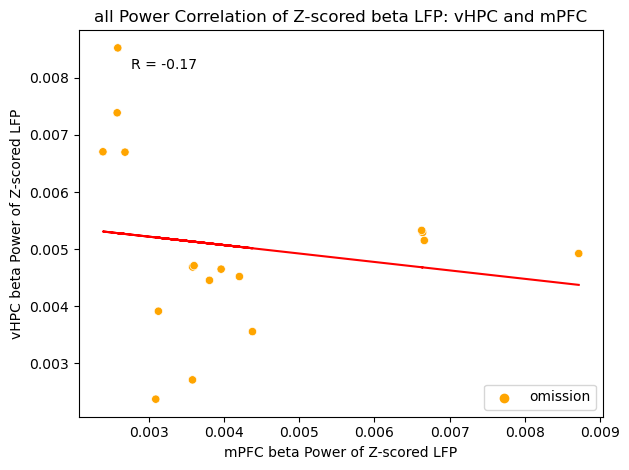

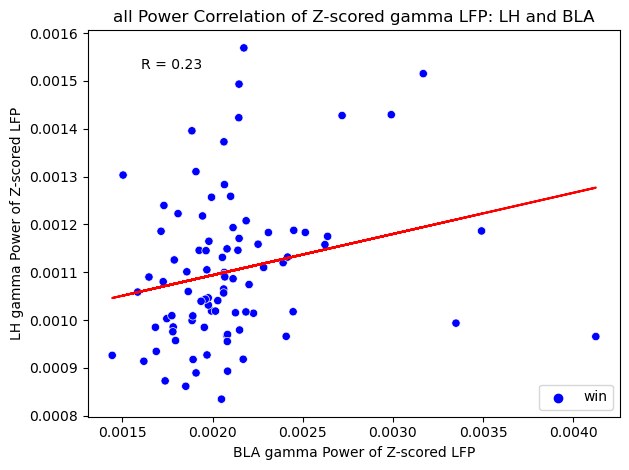

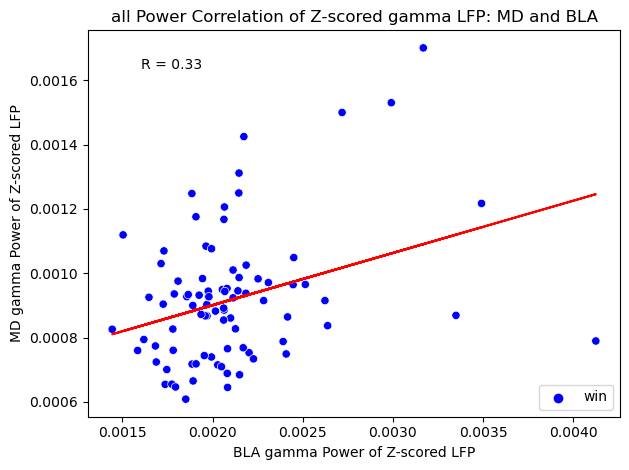

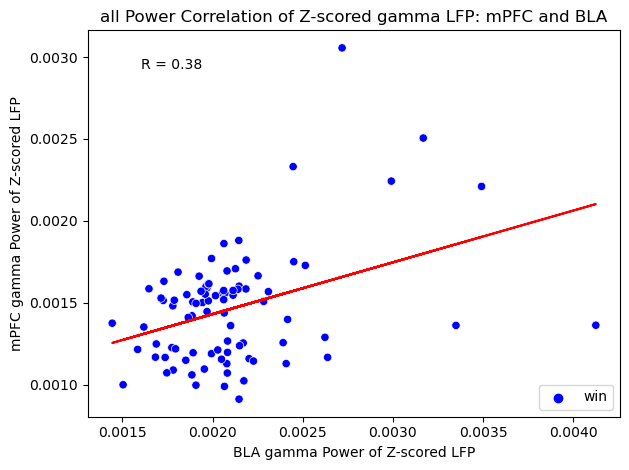

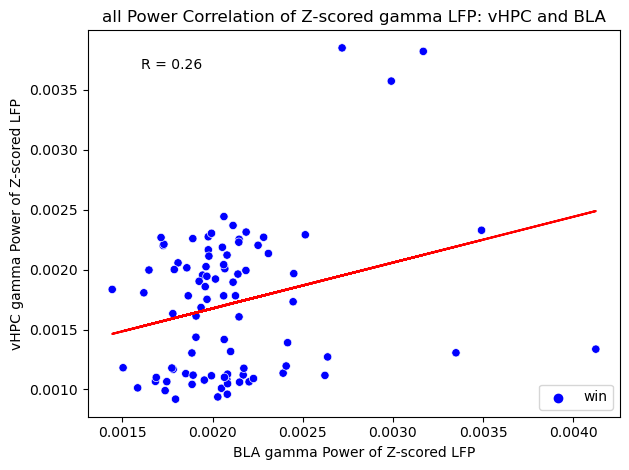

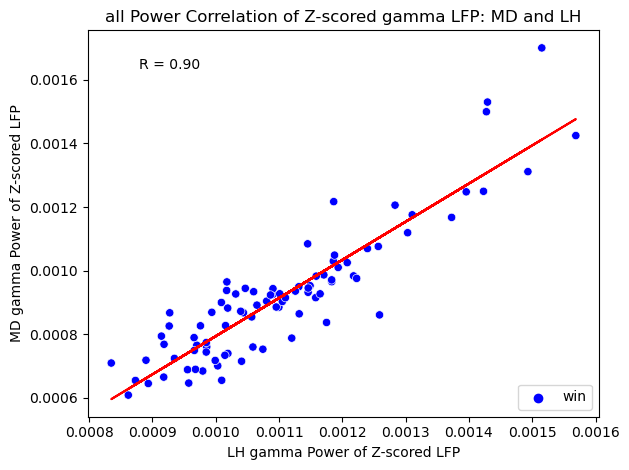

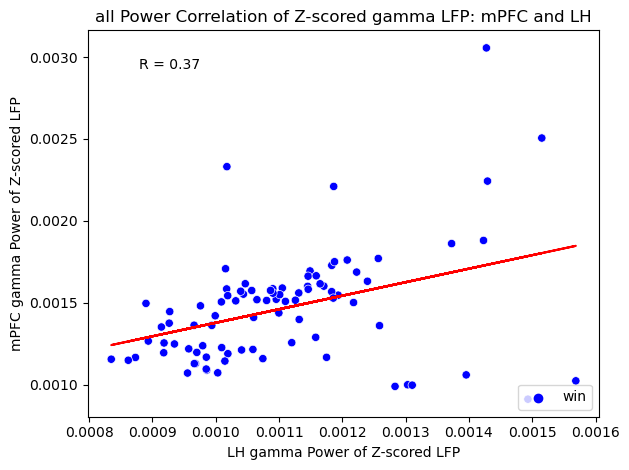

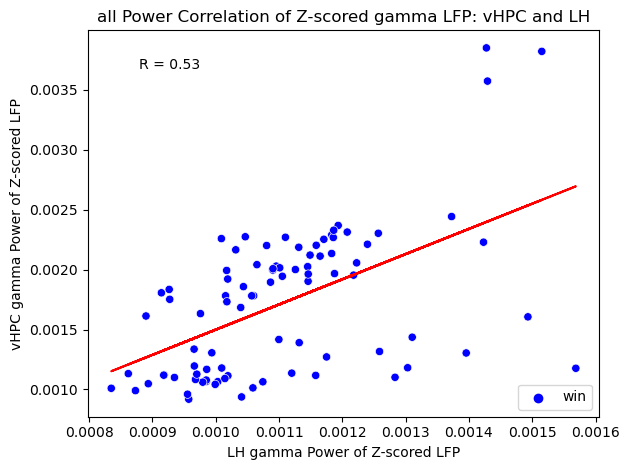

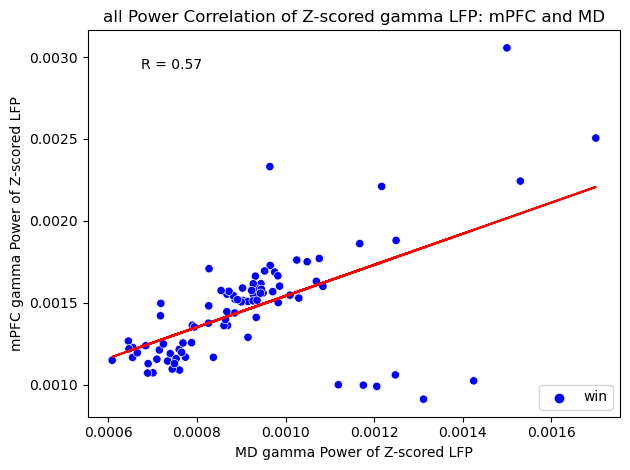

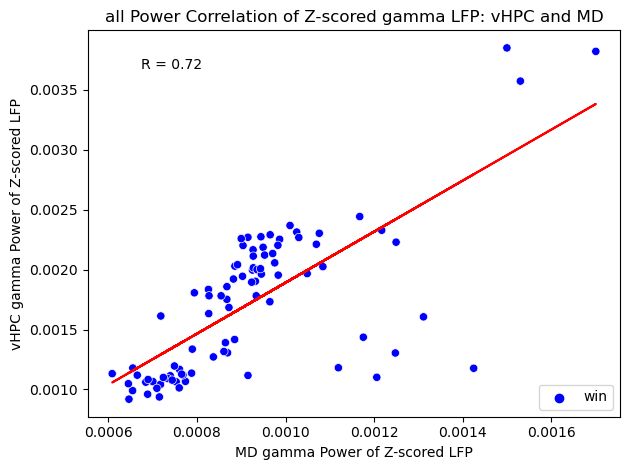

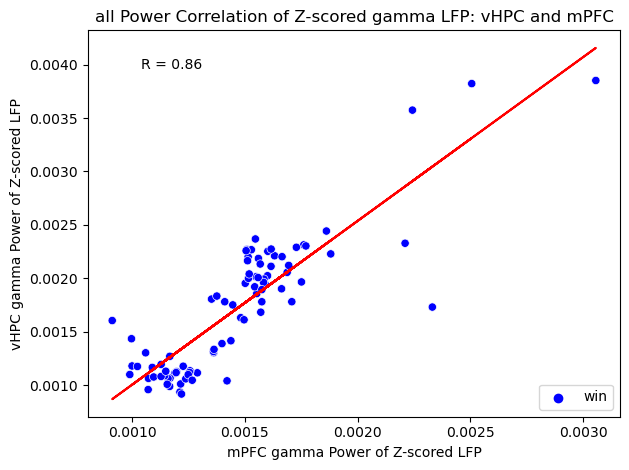

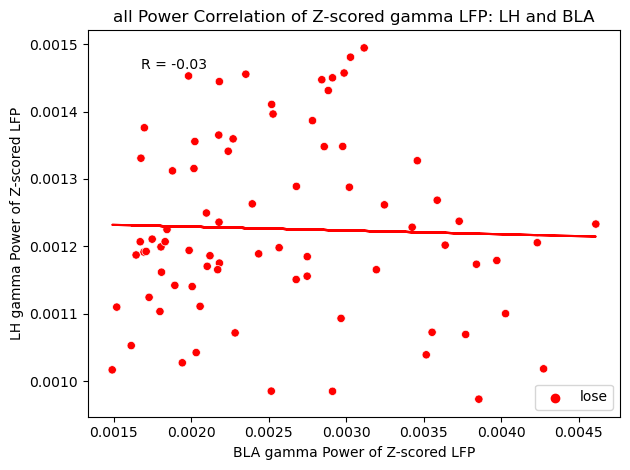

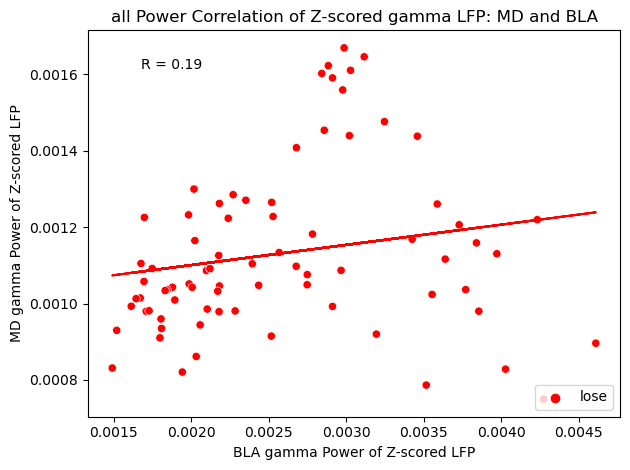

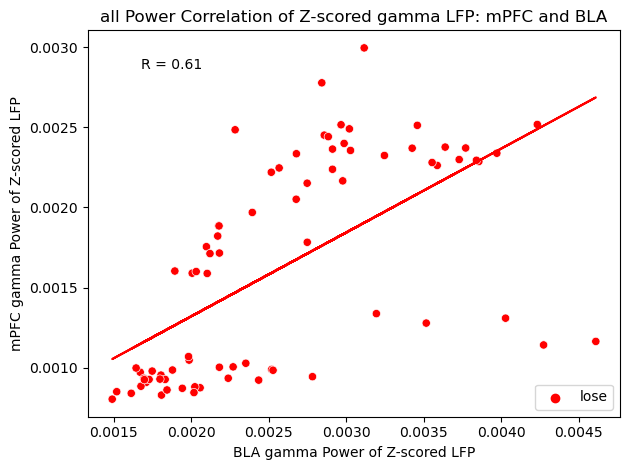

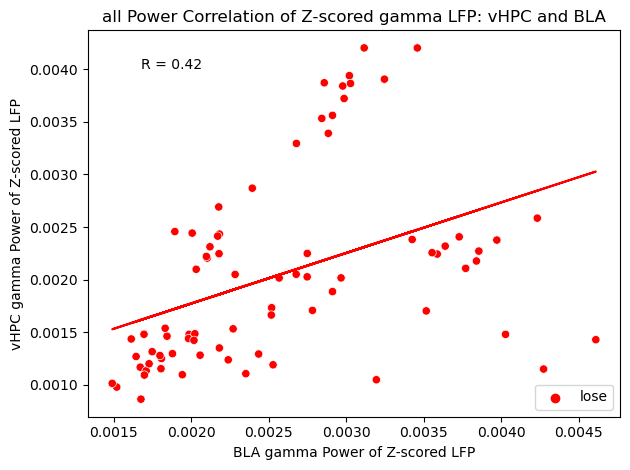

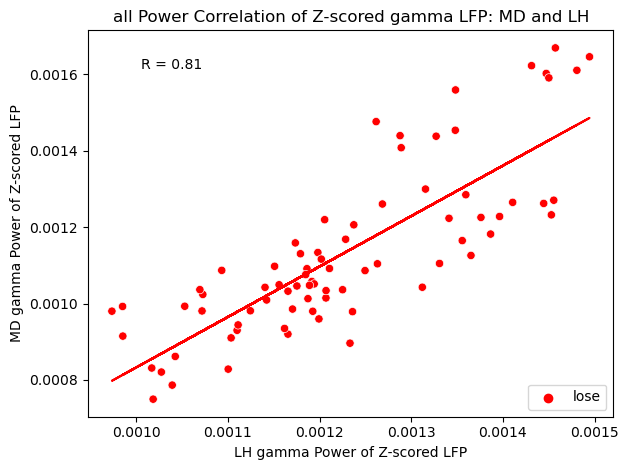

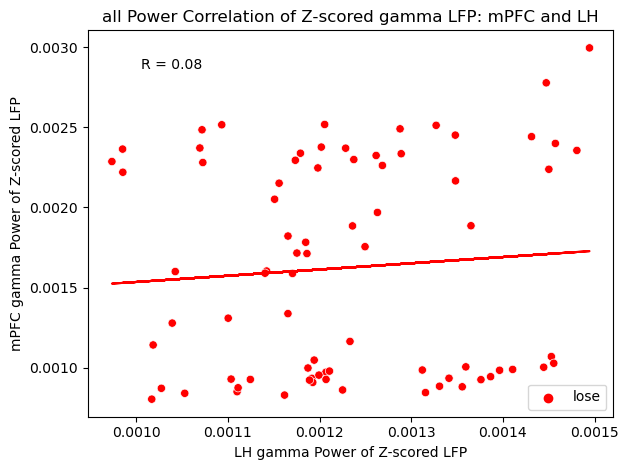

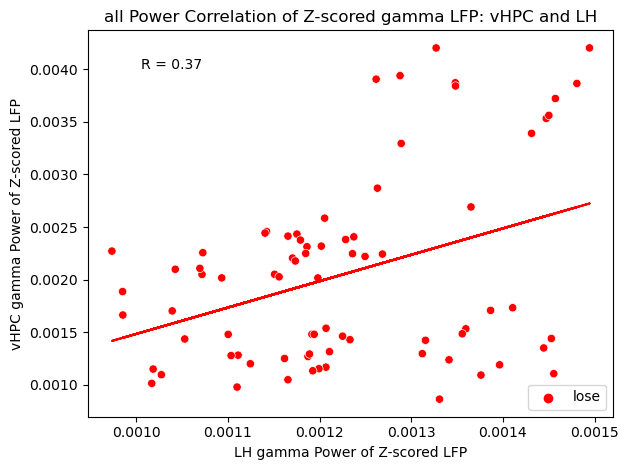

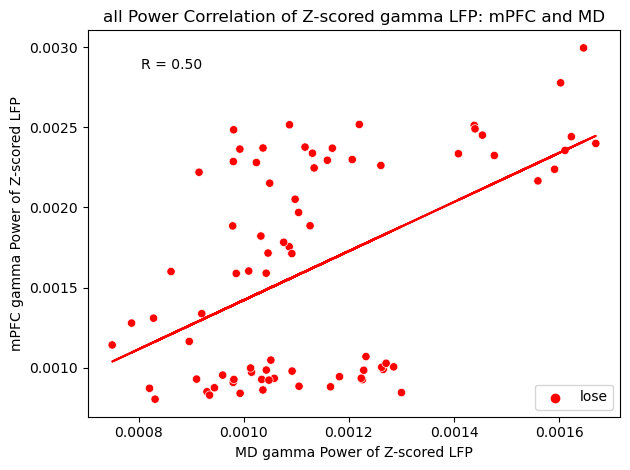

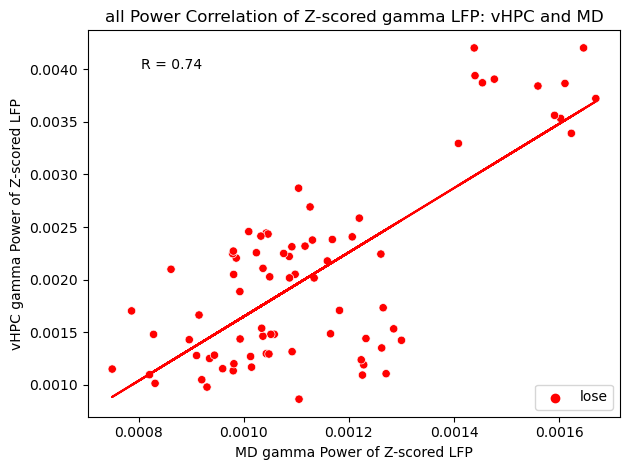

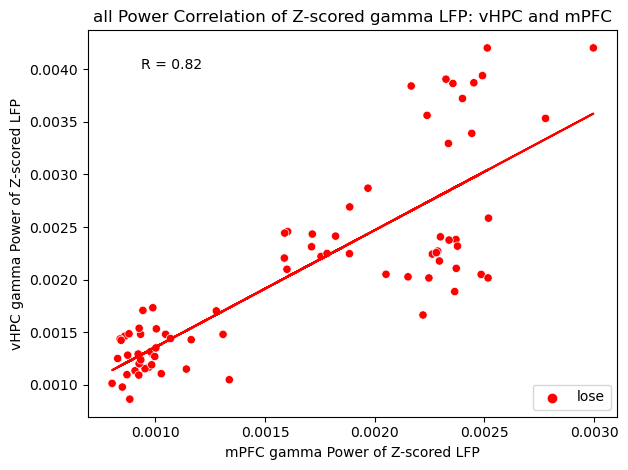

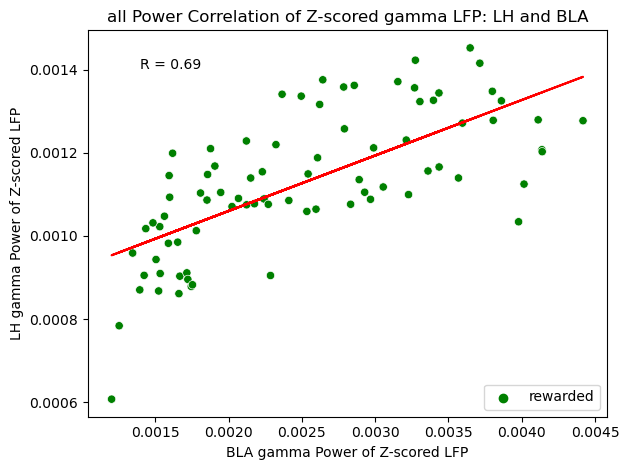

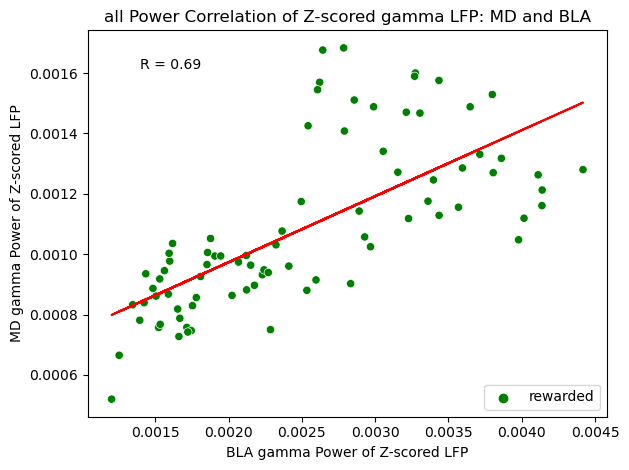

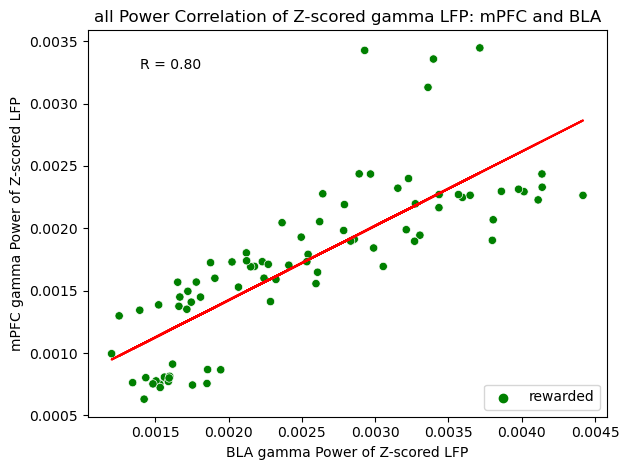

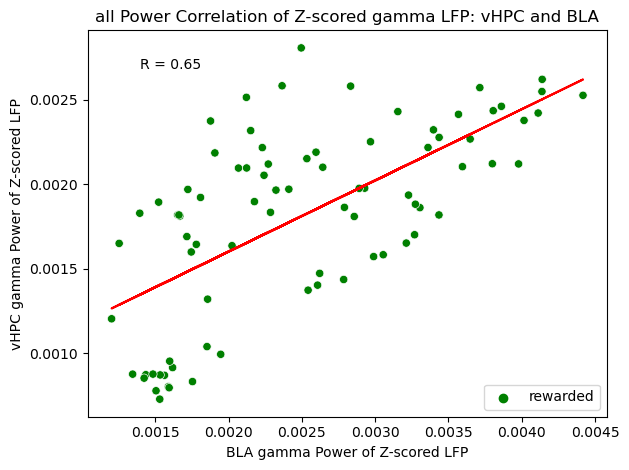

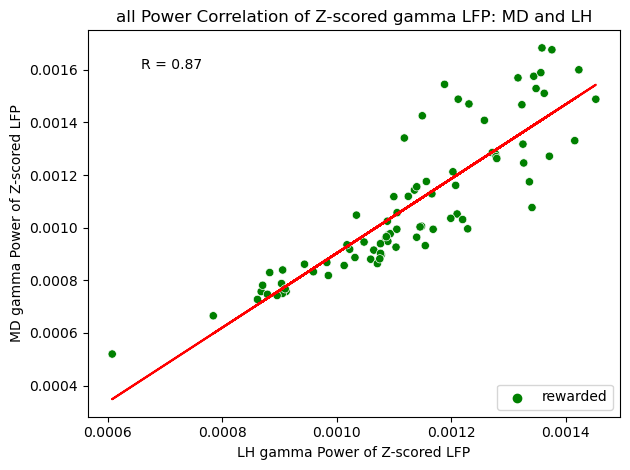

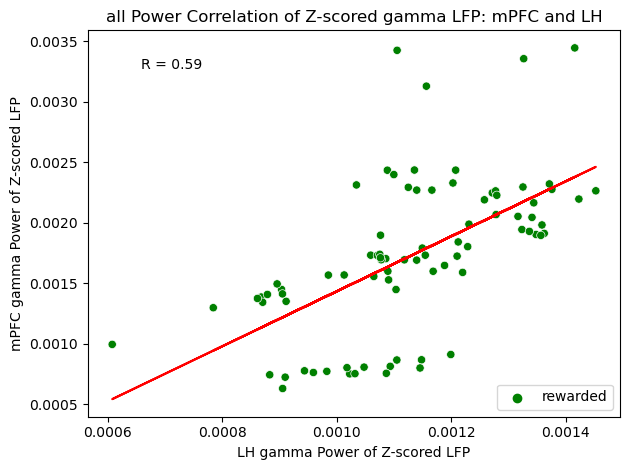

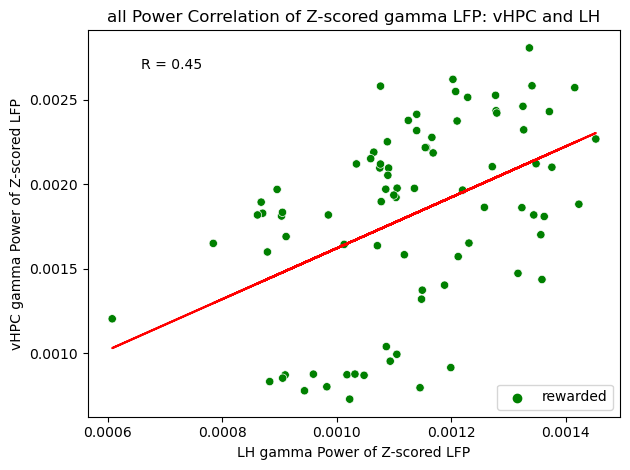

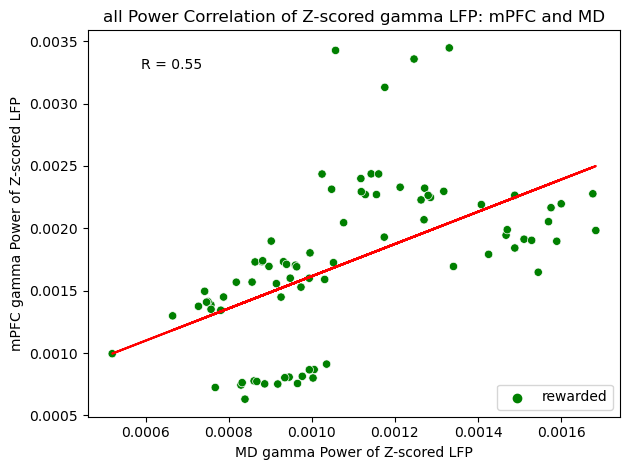

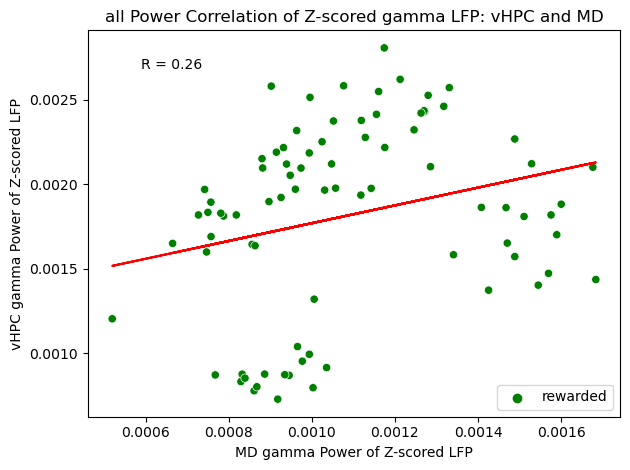

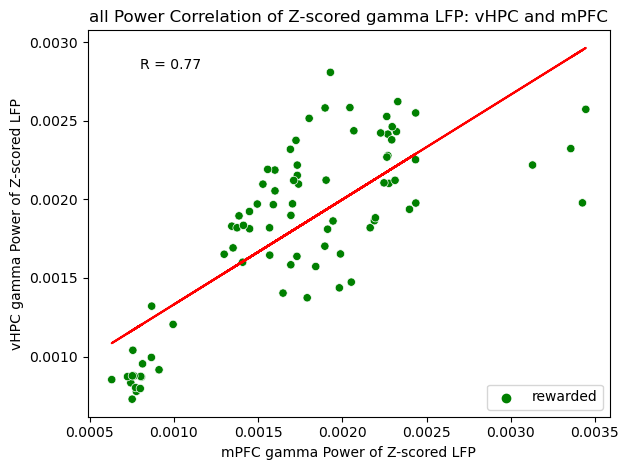

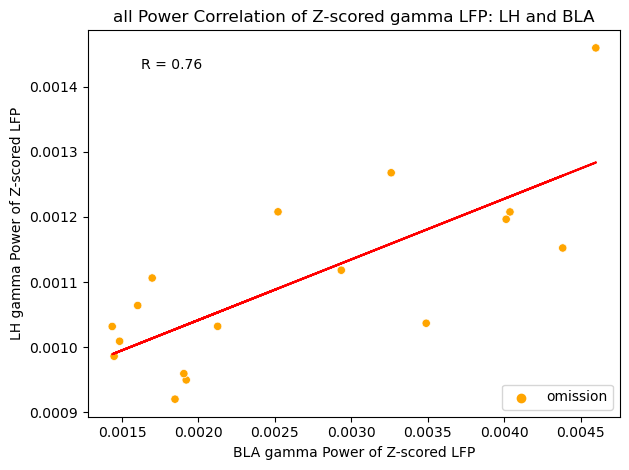

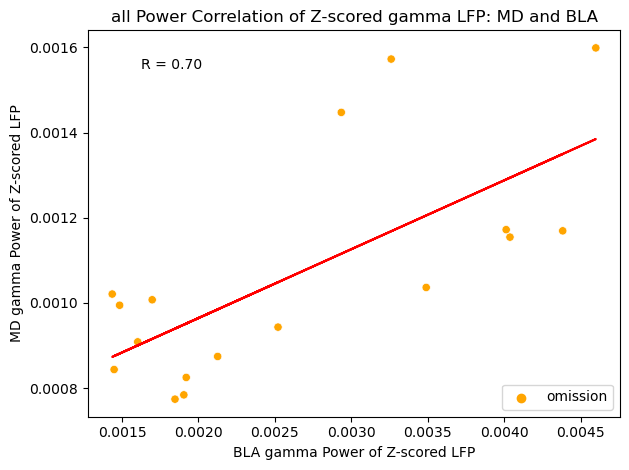

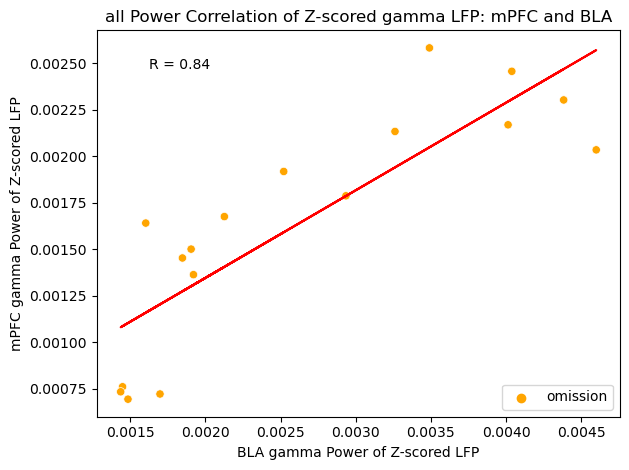

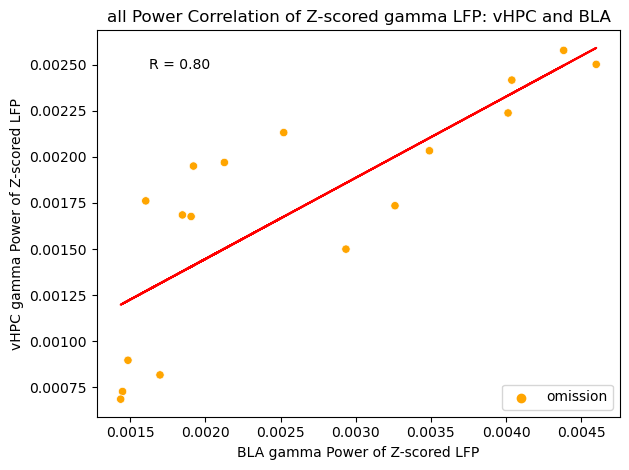

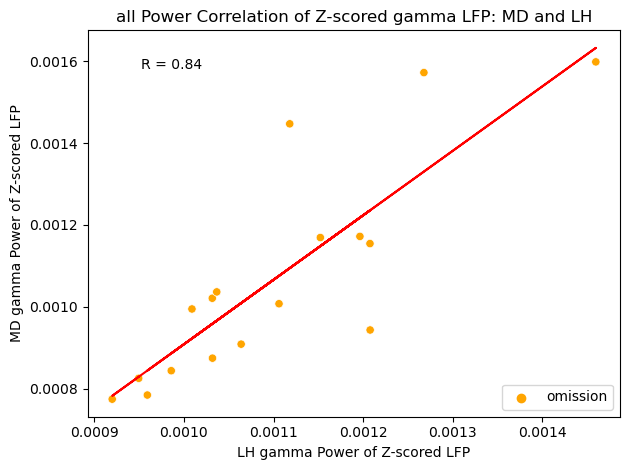

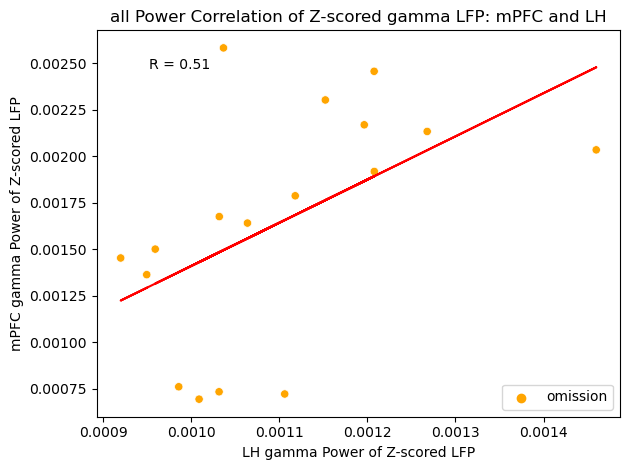

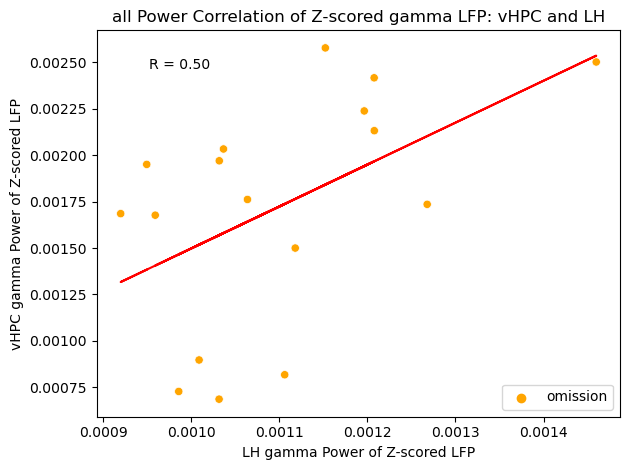

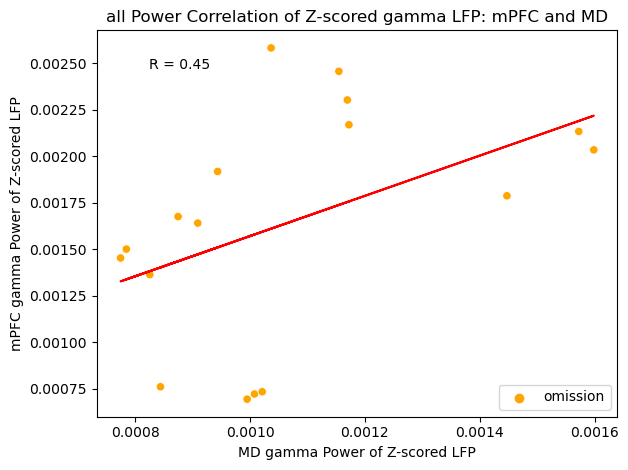

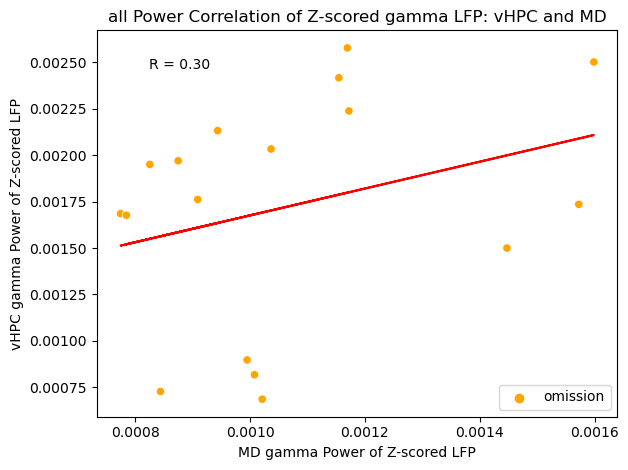

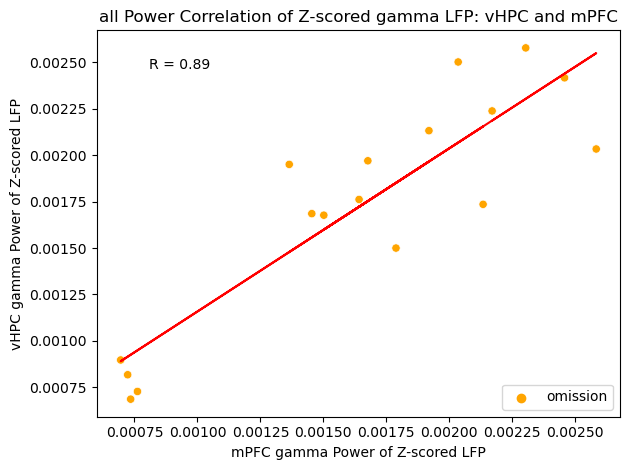

In [42]:
for band in ALL_BANDS:
    band_df = band_to_power_correlation[band]["outlier_removed_df"]
    band_to_power_correlation[band]["region_pair_to_outcome_to_r2"] = defaultdict(nested_dict)
    for outcome in band_df["trial_outcome"].unique():
        outcome_df = band_df[band_df["trial_outcome"] == outcome]
        for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
            region_1_basename = region_1.split("_")[0]
            region_2_basename = region_2.split("_")[0]
            
            x = outcome_df[region_1]
            y = outcome_df[region_2]
            
            # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            # Square the r value to get the r squared value
            r2_value = r_value**2
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
            
            # Create a line of best fit using the slope and intercept
            line = slope * x + intercept
            
            # Create scatter plot
            sns.scatterplot(x=x, y=y, data=outcome_df, hue='trial_outcome', palette=BASELINE_OUTCOME_TO_COLOR)
            
            # Plot line of best fit
            plt.plot(x, line, color='red')
            
            # Add R² value to the plot
            plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
            
            # Add labels and legend
            plt.title("{} Power Correlation of Z-scored {} LFP: {} and {}".format(GROUPING, band, region_2_basename, region_1_basename))
            plt.xlabel('{} {} Power of Z-scored LFP'.format(region_1_basename, band))
            plt.ylabel('{} {} Power of Z-scored LFP'.format(region_2_basename, band))
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig("./proc/power_correlation/{}/{}_{}_{}_{}_{}_power_correlation_of_zscored_lfp.png".format(GROUPING, GROUPING, band, outcome, region_1_basename, region_2_basename, band))
            # Display the plot
            plt.show()

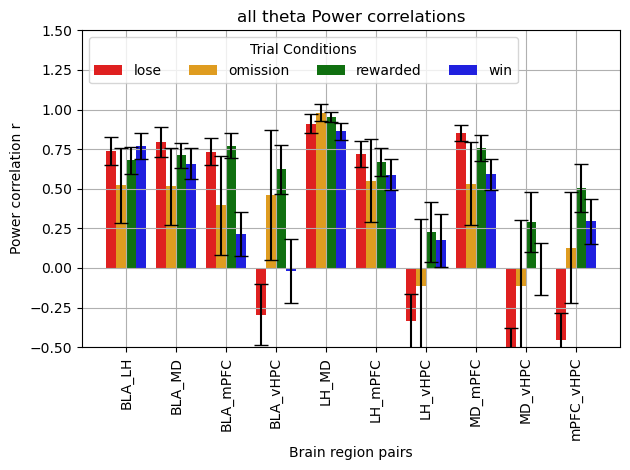

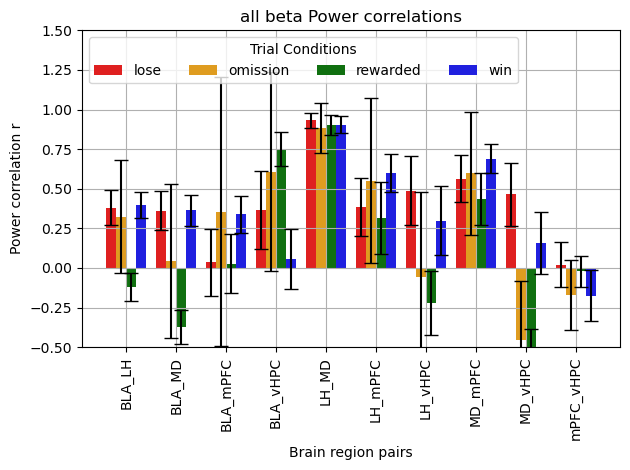

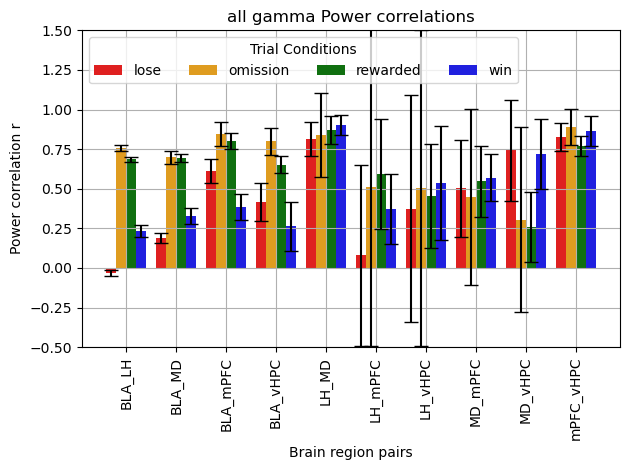

In [43]:
for band in ALL_BANDS:
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in band_to_power_correlation[band]['region_pair_to_outcome_to_r2'].items():
        for bar_name, bar_dict in sorted(group_data.items()):
            data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
            
    df = pd.DataFrame(data)
    df["color"] = df["Bar"].map(BASELINE_OUTCOME_TO_COLOR)
    # Create the bar plot using seaborn
    # sns.catplot(
    #     data=df, 
    #     x='Group', 
    #     y='r2', 
    #     hue='Bar', 
    #     kind='bar', 
    #     height=4, 
    #     aspect=2,
    #     legend=False,
    #     # yerr=df['std'].values,  # This line adds the SEM bars
    #     # capsize=0.1  # This line adds caps on the error bars
    # )
    
    # Create barplot
    ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None, palette=df["color"])
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
        plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)
    
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Power correlation r")
    plt.title("{} {} Power correlations".format(GROUPING, band))
    # plt.tight_layout()
    plt.grid()
    plt.ylim(-0.5,1.5)
    plt.tight_layout()
    plt.legend(title="Trial Conditions", ncol=4, loc="upper left")

    
    plt.savefig("./proc/power_correlation/{}_zscored_{}_lfp_power_correlation.png".format(GROUPING, band))
    # Show the plot
    plt.show()